### Problem Overview- Solar Frontier Capital (SFC) a pay as you go solar solutions provider, operates a system where users take on a solar contract and purchase tokens to have access to solar energy depending on their needs, the amount of tokens determine the solar units available. In order to properly plan their business and optimize revenues, SFC requires a machine learning solution for forecasting expected payements(variable payments are made depending on the user needs) by users in the next 6 months given historical payment statistics and metadata about users.


### Solution Approach-  My approach(2nd place unofficial solution) on the leaderboard. 

***The approach involves determining***:

***1) Payment statistics of users by months, occupation, region***

***2) Extracting last 5 payments of users and payment months***

***3) Extracting features related to expected payment window, amounts and actual window, amounts***

***4) Building a loan status classification model to first determine if the contract will be fully paid or not. This helps in the model scaling of predictions***

***5) Using the m which represents the next 6 months (m1-m6) as features***

***6) Using the above features and loan status, payment is predicted for the 6 months***

### These notebook details the data preparation for loan status and payment amount predictions.

In [2]:
import os
import ast
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm.std import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from pandas.tseries.offsets import DateOffset
from dateutil import relativedelta
import re
import random
rand = 40
np.random.seed(rand)
random.seed(rand)
tqdm.pandas()

import logging
logging.basicConfig(level='INFO')


logging.info(msg=f"Using tensorflow version : {tf.__version__}")


###Consider creating the groupby features using the actual PaymentsHistory, appending the lists. Compare in Cross-Validation which is best

C:\Users\Damola\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Damola\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Damola\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Damola\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [3]:
import warnings
warnings.filterwarnings(action="ignore")

## Config & Helpers funcs

In [198]:
class Config:
    data_dir = './data/'
    working_dir = './src/'
    models_dir = './models/'
    submissions_dir = './submissions'
    
    
    
def create_target(df:pd.DataFrame, window:int=2):
    
    """
    Compute a target column : Compared to the overall contract value, this column will be the answer to the following question-
    (What is the fraction of the expected loan status in the next 6 months-  Greater than contract value or less than Contract value?)
    (Overall target for modelling will be is loan status predicted to fully paid 1, overpaid 2 or underpaid 0)
        Parameters
        ----------
            df : pandas dataframe - like
                dataframe to add targets to. (should contain the payments history)
                
            window : int
                number of repeated term(s) to look at
                
        Returns
        -------
        
            df : pandas dataframe - like
                dataframe with a 'Target' column
    """
    try:
        df = df.copy()
        
        
        targets = []
        
        for r in df.iterrows():
            r = r[1]
            target = 100 * ((sum(ast.literal_eval(r.PaymentsHistory)) + \
                             sum(r[['m1', 'm2', 'm3', 'm4', 'm5', 'm6']].values.tolist())) / r.TotalContractValue)
                        
            targets.append(float(target))
            
        df["Target"] = targets
        
        del targets
    
        return df
    
    except Exception as ex:
        logging.error(msg=f'{ex}')
        
        return None   

# Dataset
---
1. Load files
2. Exploratory Data Analysis (EDA)
3. Preprocess data
4. Extract features

In [5]:
train = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "Train.csv"))
metadata = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "metadata.csv"))
test = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "Test.csv"))
ss = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "SampleSubmission.csv"))

## EDA

**Load Datasets**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28007 entries, 0 to 28006
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                28007 non-null  object 
 1   TransactionDates  28007 non-null  object 
 2   PaymentsHistory   28007 non-null  object 
 3   m1                28007 non-null  float64
 4   m2                28007 non-null  float64
 5   m3                28007 non-null  float64
 6   m4                28007 non-null  float64
 7   m5                28007 non-null  float64
 8   m6                28007 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


In [7]:
train.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
m1,28007.0,815.411683,686.130805,1.0,275.0,820.0,1200.0,33890.0
m2,28007.0,807.101617,839.772177,1.0,250.0,800.0,1200.0,94044.0
m3,28007.0,797.641161,696.809281,1.0,220.0,790.0,1200.0,32005.0
m4,28007.0,815.011033,715.582046,1.0,230.0,815.0,1200.0,33403.0
m5,28007.0,827.719463,796.379837,1.0,220.0,840.0,1205.0,64106.0
m6,28007.0,692.115150,1416.301221,1.0,130.0,480.0,915.0,96814.0


In [8]:
train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0


***Check TransactionDates sequential***

In [9]:
def check_sequential(df):
    
    not_arranged = 0
    
    x = ast.literal_eval(df)
    
    for i in range(1, len(x)):
    
        if pd.to_datetime(x[i-1]) > pd.to_datetime(x[i]):
        
            not_arranged += 1
        
    return not_arranged
        
        
    
    

In [10]:
not_arranged_train = train['TransactionDates'].progress_apply(check_sequential)

100%|███████████████████████████████████████████████████████████████████████████| 28007/28007 [02:21<00:00, 197.95it/s]


In [11]:
not_arranged_train.sum()

0

In [12]:
not_arranged_test = test['TransactionDates'].progress_apply(check_sequential)

100%|█████████████████████████████████████████████████████████████████████████████| 9336/9336 [00:47<00:00, 198.61it/s]


In [13]:
not_arranged_test.sum()

0

**Are the length of transaction dates/payments history same for all users**

In [14]:
def create_len(df):
    
    return len(df.strip('[]').split(' '))

In [15]:
train['payhist_len'] = train['PaymentsHistory'].apply(create_len)

train['paydates_len'] = train['TransactionDates'].apply(create_len)


test['payhist_len'] = test['PaymentsHistory'].apply(create_len)

test['paydates_len'] = test['TransactionDates'].apply(create_len)


In [16]:
#confirm payhist len and paydates len are exactly same

print(len(train[train['payhist_len'] == train['paydates_len']]) / len(train))

print(len(test[test['payhist_len'] == test['paydates_len']]) / len(test))

1.0
1.0


In [17]:
train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,paydates_len
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,31
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,30
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,6
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,10
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,22


In [18]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37343 entries, 0 to 37342
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37343 non-null  object 
 1   RegistrationDate     37343 non-null  object 
 2   Deposit              37343 non-null  int64  
 3   UpsellDate           973 non-null    object 
 4   AccessoryRate        37343 non-null  float64
 5   PaymentMethod        37343 non-null  object 
 6   rateTypeEntity       37343 non-null  object 
 7   RatePerUnit          37343 non-null  int64  
 8   DaysOnDeposit        37343 non-null  int64  
 9   MainApplicantGender  37343 non-null  object 
 10  Age                  30404 non-null  float64
 11  Region               35409 non-null  object 
 12  Town                 37343 non-null  object 
 13  Occupation           37343 non-null  object 
 14  SupplierName         37343 non-null  object 
 15  Term                 37343 non-null 

In [19]:
metadata.head()

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,41.0,Mount Kenya Region,Embu,Other,d_light,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35,2016-10-23 04:52:30
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Male,33.0,Coast Region,Kilifi,Other,d_light,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03,2020-05-24 15:32:18
2,ID_102CV85,2015-12-18 00:00:00,2000,2018-03-29 10:14:58,35.0,FINANCED,DAILY,35,7,Female,48.0,Nairobi Region,Makueni,Business,d_light,392,29480.0,2017-01-13 00:00:00,2015-12-18 06:22:34,2017-02-01 15:23:44
3,ID_HXBJFHB,2015-11-25 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,43.0,NaN,UNKNOWN,Teacher,d_light,364,14740.0,2016-11-23 00:00:00,2015-11-25 13:25:57,2017-05-22 16:46:54
4,ID_3K9VZ5J,2015-12-02 00:00:00,2000,NaN,0.0,FINANCED,DAILY,35,7,Female,56.0,Mount Kenya Region,Kirinyaga,Other,d_light,364,14740.0,2016-11-30 00:00:00,2015-12-05 10:34:32,2017-05-12 16:50:52


In [20]:
metadata.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
Deposit,37343.0,2348.631685,417.814614,0.0,2000.0,2000.0,2500.0,8000.0
AccessoryRate,37343.0,1.136090,7.791789,0.0,0.0,0.0,0.0,240.0
RatePerUnit,37343.0,49.923868,57.500215,35.0,40.0,40.0,55.0,4000.0
DaysOnDeposit,37343.0,4.600835,3.429060,0.0,3.0,3.0,7.0,60.0
Age,30404.0,38.855677,12.300827,19.0,29.0,36.0,46.0,120.0
Term,37343.0,412.427657,121.602544,10.0,364.0,364.0,547.0,626.0
TotalContractValue,37343.0,22953.005142,10149.863172,10800.0,16560.0,16560.0,33080.0,64484.0


In [21]:
#dropping leakage feature once loaded

metadata = metadata.drop(['LastPaymentDate'], axis = 1)

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9336 entries, 0 to 9335
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                9336 non-null   object
 1   TransactionDates  9336 non-null   object
 2   PaymentsHistory   9336 non-null   object
 3   payhist_len       9336 non-null   int64 
 4   paydates_len      9336 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 364.8+ KB


In [23]:
test.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
payhist_len,9336.0,16.322943,9.309551,5.0,8.0,14.0,23.0,41.0
paydates_len,9336.0,16.322943,9.309551,5.0,8.0,14.0,23.0,41.0


In [24]:
test.head(n=2)

,ID,TransactionDates,PaymentsHistory,payhist_len,paydates_len
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]",6,6
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ...",7,7


In [25]:
print("---------------- Missing values Report ----------------")
print(train.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
m1                  0
m2                  0
m3                  0
m4                  0
m5                  0
m6                  0
payhist_len         0
paydates_len        0
dtype: int64


In [26]:
print("---------------- Missing values Report ----------------")
print(test.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
payhist_len         0
paydates_len        0
dtype: int64


In [27]:
print("---------------- Missing values Report ----------------")
print(metadata.isna().sum())

---------------- Missing values Report ----------------
ID                         0
RegistrationDate           0
Deposit                    0
UpsellDate             36370
AccessoryRate              0
PaymentMethod              0
rateTypeEntity             0
RatePerUnit                0
DaysOnDeposit              0
MainApplicantGender        0
Age                     6939
Region                  1934
Town                       0
Occupation                 0
SupplierName               0
Term                       0
TotalContractValue         0
ExpectedTermDate           0
FirstPaymentDate           0
dtype: int64


**Merge data files** 

In [28]:
train['tag'] = 'train'
test['tag'] = 'test'

In [29]:
#train & test merged
all_data = pd.concat([train, test])

In [30]:
all_data.reset_index(inplace = True, drop = True)

In [31]:
all_data

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,paydates_len,tag
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,31,train
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,30,train
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,6,train
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,10,train
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,22,train
...,...,...,...,...,...,...,...,...,...,...,...,...
37338,ID_ATLMXQX,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2690.0, 270.0, 770.0, 1100.0, 700.0, 550.0, 5...",NaN,NaN,NaN,NaN,NaN,NaN,10,10,test
37339,ID_DYMC72D,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2950.0, 1550.0, 1500.0, 900.0, 80.0, 1550.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,9,9,test
37340,ID_5CBGHCN,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2550.0, 500.0, 550.0, 250.0, 200.0, 450.0, 45...",NaN,NaN,NaN,NaN,NaN,NaN,10,10,test
37341,ID_HYHB585,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2700.0, 800.0, 250.0, 300.0, 1100.0, 950.0, 8...",NaN,NaN,NaN,NaN,NaN,NaN,10,10,test


In [32]:
merged = pd.merge(left = all_data, right = metadata, on = "ID", how = 'left')

In [33]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate'],
      dtype='object')

In [34]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,Male,NaN,Coast Region,Kwale,Teacher,d_light,556,33080.0,2019-10-31 12:28:05,2018-04-23 12:28:05
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,Male,26.0,South Rift,Narok,Farmer,d_light,556,33080.0,2019-10-25 10:27:35,2018-04-17 10:27:35
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,Male,21.0,Mount Kenya Region,Embu,Business,d_light,240,14400.0,2020-10-15 14:23:44,2020-02-18 14:23:48
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,Female,26.0,Mount Kenya Region,Meru,Farmer,d_light,364,16560.0,2018-09-13 11:07:40,2017-09-14 11:07:32
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,Male,27.0,North Rift,West Pokot,Farmer,d_light,364,16560.0,2018-09-05 06:50:20,2017-09-06 06:50:16


In [35]:
merged.dtypes

ID                      object
TransactionDates        object
PaymentsHistory         object
m1                     float64
m2                     float64
m3                     float64
m4                     float64
m5                     float64
m6                     float64
payhist_len              int64
paydates_len             int64
tag                     object
RegistrationDate        object
Deposit                  int64
UpsellDate              object
AccessoryRate          float64
PaymentMethod           object
rateTypeEntity          object
RatePerUnit              int64
DaysOnDeposit            int64
MainApplicantGender     object
Age                    float64
Region                  object
Town                    object
Occupation              object
SupplierName            object
Term                     int64
TotalContractValue     float64
ExpectedTermDate        object
FirstPaymentDate        object
dtype: object

In [36]:
#Check unique users

merged['ID'].nunique()/len(merged)

1.0

In [37]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate'],
      dtype='object')

In [38]:
all_cols = ['TransactionDates', 'PaymentsHistory', 
       'payhist_len', 'paydates_len', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate']

In [39]:
#Check duplicate data

merged[merged[all_cols].duplicated(keep = False)][all_cols]

,TransactionDates,PaymentsHistory,payhist_len,paydates_len,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,...,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate


In [40]:
#Extract columns

def Column_types():

    skip_cols = ['tag', 'ID']
    cols = [col for col in merged.columns if col not in skip_cols]
    cat_cols = [col for col in cols if merged[col].dtype == 'O' and 'Date' not in col]
    date_cols = [col for col in cols if 'Date' in col]
    num_cols = list(set(cols)-set(cat_cols + date_cols))
    
    return cat_cols, date_cols, num_cols

In [41]:
cat_cols, date_cols, num_cols = Column_types()

### Exploratory Data Analysis on the datatypes

#### DATE

In [42]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate'],
      dtype='object')

In [43]:
merged[date_cols]

,TransactionDates,RegistrationDate,UpsellDate,ExpectedTermDate,FirstPaymentDate
0,"['04-2018', '05-2018', '06-2018', '07-2018', '...",2018-04-23 12:28:05,NaN,2019-10-31 12:28:05,2018-04-23 12:28:05
1,"['04-2018', '05-2018', '06-2018', '07-2018', '...",2018-04-17 10:27:35,NaN,2019-10-25 10:27:35,2018-04-17 10:27:35
2,"['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-18 14:23:44,NaN,2020-10-15 14:23:44,2020-02-18 14:23:48
3,"['09-2017', '10-2017', '11-2017', '12-2017', '...",2017-09-14 11:07:40,NaN,2018-09-13 11:07:40,2017-09-14 11:07:32
4,"['09-2017', '10-2017', '11-2017', '12-2017', '...",2017-09-06 06:50:20,NaN,2018-09-05 06:50:20,2017-09-06 06:50:16
...,...,...,...,...,...
37338,"['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 16:29:42,NaN,2020-10-17 16:29:42,2020-02-20 16:29:50
37339,"['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 16:53:23,NaN,2020-10-17 16:53:23,2020-02-20 16:53:40
37340,"['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 17:09:47,NaN,2020-10-17 17:09:47,2020-02-20 17:10:25
37341,"['02-2020', '03-2020', '04-2020', '05-2020', '...",2020-02-20 17:13:35,NaN,2020-10-17 17:13:35,2020-02-20 17:14:00


***Analysis - Confirming the first date of TransactionDates is same as First Payment date***

In [44]:
def check_dates_format(df, col, axis):
    
    date = pd.to_datetime(df[col]).strftime("%m-%Y")
    
    first_date_transaction = ast.literal_eval(df['TransactionDates'])[axis]
    
    return date == first_date_transaction
    
    

In [45]:
#FirstPaymentDate is First date from TransactionDates 
first_date_check = merged.apply(check_dates_format, axis = 1, args = ['FirstPaymentDate', 0])

In [46]:
#RegistrationDate is First date from TransactionDates 
register_date_check = merged.apply(check_dates_format, axis = 1, args = ['RegistrationDate', 0])

In [47]:
print(first_date_check.sum())

print(register_date_check.sum())



37343
37333


***Analysis- Is there any pattern related to users who have a different registration date and first payment date?***

In [48]:
merged.iloc[list(register_date_check[register_date_check == False].index)]

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate
10083,ID_DBXI5V3,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[2840.0, 525.0, 560.0, 665.0, 648.0, 735.0, 80...",120.0,340.0,135.0,400.0,440.0,189.0,24,...,Male,49.0,Nairobi Region,Makueni,Other,d_light,364,14740.0,2016-11-28 00:00:00,2015-12-01 08:00:33
10789,ID_N1R96SK,"['03-2018', '06-2018', '08-2018', '09-2018', '...","[7700.0, 1650.0, 2675.0, 1000.0, 1444.0, 770.0...",1130.0,1678.0,1084.0,1065.0,2763.0,1350.0,12,...,Male,36.0,Nyanza,Kisumu,Other,d_light,547,33084.0,2019-08-05 08:09:49,2018-03-02 04:24:52
11215,ID_MRQT9SX,"['02-2018', '03-2018', '04-2018', '06-2018', '...","[2000.0, 1200.0, 1280.0, 1200.0, 920.0, 918.0,...",160.0,1040.0,580.0,40.0,640.0,720.0,30,...,Male,80.0,Nyanza,Kisumu,Farmer,d_light,364,16560.0,2019-01-30 18:48:06,2018-02-01 05:34:36
11486,ID_94RMUU4,"['10-2016', '11-2016', '12-2016', '01-2017', '...","[3040.0, 1280.0, 1120.0, 1320.0, 1180.0, 1090....",700.0,990.0,679.0,580.0,739.0,1022.0,9,...,Female,51.0,Nyanza,Kisii,Farmer,d_light,395,34120.0,2017-10-30 18:10:02,2016-10-09 16:00:30
13450,ID_2Y1YG5N,"['01-2017', '07-2017', '08-2017', '09-2017', '...","[1250.0, 3200.0, 320.0, 1200.0, 1300.0, 1200.0...",1320.0,920.0,1000.0,1200.0,1000.0,340.0,12,...,Male,45.0,Western,Kakamega,Other,d_light,364,16560.0,2018-07-05 11:36:45,2017-01-05 16:00:51
15241,ID_QI7FJVT,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2999.0, 1370.0, 1615.0, 1525.0, 1350.0, 1565....",1245.0,1320.0,1030.0,1160.0,1635.0,1057.0,17,...,Female,NaN,North Rift,Trans Nzoia,Business,d_light,547,33084.0,2019-09-20 17:37:24,2018-04-05 08:39:13
17575,ID_1C0WV6P,"['08-2017', '09-2017', '10-2017', '11-2017', '...","[2328.0, 280.0, 280.0, 100.0, 280.0, 40.0, 140...",100.0,80.0,100.0,640.0,1000.0,760.0,32,...,Male,44.0,Coast Region,Kwale,Labourer,d_light,364,16560.0,2018-07-30 08:54:02,2017-08-01 08:38:04
19353,ID_B7ZTW2J,"['08-2017', '09-2017', '10-2017', '11-2017', '...","[2840.0, 1200.0, 1180.0, 1170.0, 1200.0, 1130....",440.0,1200.0,1240.0,1100.0,1220.0,40.0,10,...,Female,24.0,Coast Region,Tana River,Business,d_light,364,16560.0,2018-07-30 10:14:43,2017-08-01 06:39:57
28050,ID_8CV4H96,"['02-2017', '03-2017', '04-2017', '05-2017', '...","[2000.0, 840.0, 920.0, 640.0, 600.0, 520.0, 68...",NaN,NaN,NaN,NaN,NaN,NaN,15,...,Male,59.0,South Rift,Nakuru,Farmer,d_light,364,16560.0,2018-10-03 08:01:20,2017-02-19 16:07:44
30474,ID_AN0CN2G,"['10-2017', '11-2017', '12-2017', '01-2018', '...","[3700.0, 1200.0, 560.0, 1000.0, 1240.0, 1200.0...",NaN,NaN,NaN,NaN,NaN,NaN,15,...,Female,84.0,Western,Bungoma,Farmer,d_light,364,16560.0,2018-09-29 16:44:07,2017-10-02 11:42:32


Some of the users with different year month distribution is due to registering just at a month end

In [49]:
#Extracting Last Transaction Date

merged['LastTransactionDate'] = merged['TransactionDates'].apply(lambda x : ast.literal_eval(x)[-1])

In [50]:
pd.to_datetime(merged['LastTransactionDate'])

0       2020-11-01
1       2020-11-01
2       2020-07-01
3       2018-06-01
4       2019-11-01
           ...    
37338   2020-11-01
37339   2020-10-01
37340   2020-11-01
37341   2020-11-01
37342   2020-06-01
Name: LastTransactionDate, Length: 37343, dtype: datetime64[ns]

In [51]:
#Create the expected 6 months date

for col in [1, 2, 3, 4, 5, 6]:
    
    merged['Date m' + str(col)] = pd.to_datetime(merged['LastTransactionDate']) + DateOffset(months = col)

In [52]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastTransactionDate,Date m1,Date m2,Date m3,Date m4,Date m5,Date m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,33080.0,2019-10-31 12:28:05,2018-04-23 12:28:05,11-2020,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,33080.0,2019-10-25 10:27:35,2018-04-17 10:27:35,11-2020,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,14400.0,2020-10-15 14:23:44,2020-02-18 14:23:48,07-2020,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,16560.0,2018-09-13 11:07:40,2017-09-14 11:07:32,06-2018,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,16560.0,2018-09-05 06:50:20,2017-09-06 06:50:16,11-2019,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01


In [53]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate',
       'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4',
       'Date m5', 'Date m6'],
      dtype='object')

**Convert to datetime format for easy processing**

In [54]:
for date in ['RegistrationDate', 'UpsellDate', 'ExpectedTermDate', 'FirstPaymentDate',  \
             'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4', 'Date m5', 'Date m6']:
    
    
    merged[date] = pd.to_datetime(merged[date])

***Analysis- What is the payment schedule by most users- Monthly or daily? Are there transaction dates of the same timeline repeated?***

In [55]:
#Sum of occurences where same payment schedule appears for a user more than once in a month

merged['TransactionDates'].apply(lambda x : len(set(ast.literal_eval(x))) != len(ast.literal_eval(x))).sum()

0

In [56]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastTransactionDate,Date m1,Date m2,Date m3,Date m4,Date m5,Date m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,33080.0,2019-10-31 12:28:05,2018-04-23 12:28:05,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,33080.0,2019-10-25 10:27:35,2018-04-17 10:27:35,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,14400.0,2020-10-15 14:23:44,2020-02-18 14:23:48,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,16560.0,2018-09-13 11:07:40,2017-09-14 11:07:32,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,16560.0,2018-09-05 06:50:20,2017-09-06 06:50:16,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01


***Create new feature for months difference between last transaction date(timeline before 6months) and first, which indicates payment window of possible monthly payment counts***

In [57]:
merged['Payment_window_until6months'] =  (merged['LastTransactionDate'].dt.year - merged['FirstPaymentDate'].dt.year) * 12 +\
(merged['LastTransactionDate'].dt.month - merged['FirstPaymentDate'].dt.month)

merged['Payment_window_until6months'] = merged['Payment_window_until6months'] + 1

In [58]:
merged[['payhist_len', 'Payment_window_until6months']]

,payhist_len,Payment_window_until6months
0,31,32
1,30,32
2,6,6
3,10,10
4,22,27
...,...,...
37338,10,10
37339,9,9
37340,10,10
37341,10,10


In [59]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate',
       'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4',
       'Date m5', 'Date m6', 'Payment_window_until6months'],
      dtype='object')

***Create new feature for ratio of actual counts of historical payments to payment window of possible monthly payment counts: This indicates frequency of payments by a user***

In [60]:
merged['userpay_frequency'] = merged['payhist_len']/merged['Payment_window_until6months']

***Create new feature for months difference between Expected Contract Term date and first Payment, which indicates payment window of possible term payment counts***

In [61]:
merged['PayContract_window'] = (merged['ExpectedTermDate'].dt.year - merged['FirstPaymentDate'].dt.year) * 12 +\
(merged['ExpectedTermDate'].dt.month - merged['FirstPaymentDate'].dt.month)

merged['PayContract_window'] = merged['PayContract_window'] + 1

In [62]:
merged[['PayContract_window', 'payhist_len']].describe()

,PayContract_window,payhist_len
count,37343.000000,37343.000000
mean,14.598907,16.277509
std,4.028826,9.263537
min,1.000000,5.000000
25%,12.000000,8.000000
50%,13.000000,14.000000
75%,19.000000,23.000000
max,22.000000,52.000000


In [63]:
merged['Term'].corr(merged['PayContract_window'])

0.9973177926620618

PayContract_window(In months) is the same as Term Duration in days.

***Create Ratio Features with PayContract_window, which indicates the difference between expected contract months window and actual payemnts window***

In [64]:
merged['Contract/until6monthswindow'] = merged['PayContract_window']/merged['Payment_window_until6months']
merged['Contract/Payhist window'] = merged['PayContract_window']/ merged['payhist_len']

In [65]:
merged[['Contract/Payhist window', 'Contract/until6monthswindow']].describe()

,Contract/Payhist window,Contract/until6monthswindow
count,37343.000000,37343.000000
mean,1.131819,1.072536
std,0.516100,0.491579
min,0.142857,0.111111
25%,0.714286,0.650000
50%,1.083333,1.000000
75%,1.444444,1.428571
max,4.000000,4.000000


In [66]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,Date m2,Date m3,Date m4,Date m5,Date m6,Payment_window_until6months,userpay_frequency,PayContract_window,Contract/until6monthswindow,Contract/Payhist window
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,32,0.968750,19,0.593750,0.612903
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,32,0.937500,19,0.593750,0.633333
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,6,1.000000,9,1.500000,1.500000
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,10,1.000000,13,1.300000,1.300000
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,27,0.814815,13,0.481481,0.590909


***Create feature on current duration of contract from RegistrationDate- Current duration of contract***

In [67]:
merged['CurrentDuration'] = (merged['LastTransactionDate'] - merged['RegistrationDate']).dt.days

In [68]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate',
       'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4',
       'Date m5', 'Date m6', 'Payment_window_until6months',
       'userpay_frequency', 'PayContract_window',
       'Contract/until6monthswindow', 'Contract/Payhist window',
       'CurrentDuration'],
      dtype='object')

***Analysis - How many users are already beyond the Term Date?***

In [69]:
merged[merged['ExpectedTermDate'].dt.strftime("%Y-%m") > merged['Date m6'].dt.strftime("%Y-%m")]

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,Date m3,Date m4,Date m5,Date m6,Payment_window_until6months,userpay_frequency,PayContract_window,Contract/until6monthswindow,Contract/Payhist window,CurrentDuration
11,ID_G9GB08B,"['02-2018', '03-2018', '04-2018', '05-2018', '...","[4939.0, 1100.0, 2050.0, 1100.0, 2000.0, 1050....",950.0,2180.0,960.0,1400.0,2000.0,3235.0,12,...,2019-04-01,2019-05-01,2019-06-01,2019-07-01,12,1.000000,19,1.583333,1.583333,320
42,ID_6ZOAAYW,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[3240.0, 920.0, 2040.0, 1320.0, 1200.0, 1280.0]",1360.0,1080.0,920.0,1360.0,760.0,1080.0,6,...,2018-05-01,2018-06-01,2018-07-01,2018-08-01,6,1.000000,13,2.166667,2.166667,145
68,ID_UPHY8M7,"['02-2018', '03-2018', '04-2018', '05-2018', '...","[2999.0, 2170.0, 900.0, 1110.0, 915.0, 700.0]",890.0,100.0,50.0,100.0,110.0,55.0,6,...,2018-10-01,2018-11-01,2018-12-01,2019-01-01,6,1.000000,19,3.166667,3.166667,123
104,ID_OWBWVLI,"['03-2018', '04-2018', '05-2018', '06-2018', '...","[5130.0, 1700.0, 1700.0, 1700.0, 2500.0, 3000....",2200.0,1650.0,2200.0,1500.0,2000.0,4510.0,8,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,10,0.800000,19,1.900000,2.375000,261
130,ID_8QGFICG,"['02-2018', '03-2018', '04-2018', '05-2018', '...","[3000.0, 1375.0, 865.0, 55.0, 55.0, 110.0, 55.0]",55.0,55.0,55.0,55.0,110.0,110.0,7,...,2018-11-01,2018-12-01,2019-01-01,2019-02-01,7,1.000000,19,2.714286,2.714286,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35048,ID_T8JT2LC,"['04-2018', '05-2018', '06-2018', '08-2018', '...","[2500.0, 1440.0, 765.0, 770.0, 330.0, 1045.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,10,...,2019-05-01,2019-06-01,2019-07-01,2019-08-01,11,0.909091,20,1.818182,2.000000,276
35070,ID_V7EN60M,"['05-2018', '07-2018', '08-2018', '09-2018', '...","[5550.0, 750.0, 1400.0, 715.0, 600.0, 350.0, 5...",NaN,NaN,NaN,NaN,NaN,NaN,10,...,2019-06-01,2019-07-01,2019-08-01,2019-09-01,11,0.909091,19,1.727273,1.900000,303
35629,ID_XLP8F1Q,"['01-2020', '02-2020', '03-2020', '04-2020', '...","[3620.0, 650.0, 465.0, 1130.0, 1040.0]",NaN,NaN,NaN,NaN,NaN,NaN,5,...,2020-08-01,2020-09-01,2020-10-01,2020-11-01,5,1.000000,12,2.400000,2.400000,108
36261,ID_3GDQG8N,"['01-2020', '02-2020', '03-2020', '04-2020', '...","[3160.0, 1040.0, 1120.0, 960.0, 240.0]",NaN,NaN,NaN,NaN,NaN,NaN,5,...,2020-08-01,2020-09-01,2020-10-01,2020-11-01,5,1.000000,12,2.400000,2.400000,96


Majority of Users have ExpectedTermDate already less than the Lastpayment Date. Capture feature on the difference in days between Expected Term Date and LastTransaction Date. 

Consider target to indicate users already paid above contract value

In [70]:
merged['TermDatetoLastPayment'] = (merged['ExpectedTermDate'] - merged['LastTransactionDate']).dt.days

***Capture feature on the difference in days between Expected Term Date and m1-m6***

In [71]:
##new

for col in ['Date m1', 'Date m2', 'Date m3', 'Date m4', 'Date m5', 'Date m6']:
    
    merged['TermDateto_' + col ] = (merged['ExpectedTermDate'] - merged[col]).dt.days

In [72]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,Contract/until6monthswindow,Contract/Payhist window,CurrentDuration,TermDatetoLastPayment,TermDateto_Date m1,TermDateto_Date m2,TermDateto_Date m3,TermDateto_Date m4,TermDateto_Date m5,TermDateto_Date m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,0.593750,0.612903,922,-367,-397,-428,-459,-487,-518,-548
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,0.593750,0.633333,928,-373,-403,-434,-465,-493,-524,-554
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,1.500000,1.500000,133,106,75,44,14,-17,-47,-78
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,1.300000,1.300000,259,104,74,43,12,-18,-49,-79
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,0.481481,0.590909,785,-422,-452,-483,-514,-543,-574,-604


In [73]:
##new

for col in ['TermDateto_Date m1', 'TermDateto_Date m2', 'TermDateto_Date m3', 'TermDateto_Date m4', \
            'TermDateto_Date m5', 'TermDateto_Date m6']:
    
    merged['TermDatetoLastPayment/' + col ] = merged['TermDatetoLastPayment']/merged[col]

In [74]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,TermDateto_Date m3,TermDateto_Date m4,TermDateto_Date m5,TermDateto_Date m6,TermDatetoLastPayment/TermDateto_Date m1,TermDatetoLastPayment/TermDateto_Date m2,TermDatetoLastPayment/TermDateto_Date m3,TermDatetoLastPayment/TermDateto_Date m4,TermDatetoLastPayment/TermDateto_Date m5,TermDatetoLastPayment/TermDateto_Date m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,-459,-487,-518,-548,0.924433,0.857477,0.799564,0.753593,0.708494,0.669708
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,-465,-493,-524,-554,0.925558,0.859447,0.802151,0.756592,0.711832,0.673285
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,14,-17,-47,-78,1.413333,2.409091,7.571429,-6.235294,-2.255319,-1.358974
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,12,-18,-49,-79,1.405405,2.418605,8.666667,-5.777778,-2.122449,-1.316456
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,-514,-543,-574,-604,0.933628,0.873706,0.821012,0.777164,0.735192,0.698675


In [75]:
merged['TermDatetoLastPayment'].describe()

count    37343.000000
mean       -71.176606
std        260.629714
min      -1254.000000
25%       -251.000000
50%         15.000000
75%        130.000000
max        463.000000
Name: TermDatetoLastPayment, dtype: float64

In [76]:
#merged[date_cols]

***Analysis- What does UpsellDate mean? Was there anything unique about their Payment pattern on upsell date?***

In [77]:
upsell_analyse = merged[merged['UpsellDate'].isnull() == False]

In [78]:
upsell_analyse['UpsellDate'] = upsell_analyse['UpsellDate'].dt.strftime("%Y-%m")

In [79]:
upsell_analyse[['TransactionDates', 'UpsellDate', 'PaymentsHistory']]

,TransactionDates,UpsellDate,PaymentsHistory
19,"['10-2016', '11-2016', '12-2016', '01-2017', '...",2019-08,"[2120.0, 1080.0, 1160.0, 1200.0, 1040.0, 1200...."
46,"['04-2018', '07-2018', '08-2018', '09-2018', '...",2018-04,"[8000.0, 900.0, 1900.0, 2650.0, 2350.0, 2410.0..."
73,"['03-2018', '05-2018', '06-2018', '07-2018', '...",2018-03,"[8000.0, 1760.0, 2660.0, 2755.0, 2850.0, 2660...."
151,"['02-2018', '03-2018', '04-2018', '05-2018', '...",2018-02,"[6600.0, 2100.0, 1503.0, 2400.0, 2328.0, 2604...."
155,"['04-2018', '06-2018', '07-2018', '08-2018', '...",2018-04,"[8000.0, 3800.0, 2500.0, 1500.0, 4500.0, 2500...."
...,...,...,...
35042,"['04-2018', '06-2018', '07-2018', '08-2018', '...",2018-04,"[8000.0, 1195.0, 1535.0, 2175.0, 1815.0, 1915...."
35043,"['04-2018', '06-2018', '07-2018', '08-2018', '...",2018-04,"[8000.0, 2700.0, 3100.0, 3000.0, 3100.0, 3100...."
35073,"['05-2018', '06-2018', '07-2018', '08-2018', '...",2018-05,"[7140.0, 1140.0, 1425.0, 1330.0, 1425.0, 1805...."
35079,"['05-2018', '06-2018', '07-2018', '08-2018', '...",2018-05,"[8000.0, 2660.0, 2442.0, 2080.0, 2707.0, 4100...."


Check UpsellDate is same as FirstPaymentDate

In [80]:
upsell_analyse[upsell_analyse['FirstPaymentDate'].dt.strftime("%Y-%m") == upsell_analyse['UpsellDate']]

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,TermDateto_Date m3,TermDateto_Date m4,TermDateto_Date m5,TermDateto_Date m6,TermDatetoLastPayment/TermDateto_Date m1,TermDatetoLastPayment/TermDateto_Date m2,TermDatetoLastPayment/TermDateto_Date m3,TermDatetoLastPayment/TermDateto_Date m4,TermDatetoLastPayment/TermDateto_Date m5,TermDatetoLastPayment/TermDateto_Date m6
46,ID_XKV1Z53,"['04-2018', '07-2018', '08-2018', '09-2018', '...","[8000.0, 900.0, 1900.0, 2650.0, 2350.0, 2410.0...",2950.0,2295.0,2375.0,2795.0,2465.0,714.0,19,...,-288,-319,-349,-380,0.864035,0.760618,0.684028,0.617555,0.564470,0.518421
73,ID_9XGRX3R,"['03-2018', '05-2018', '06-2018', '07-2018', '...","[8000.0, 1760.0, 2660.0, 2755.0, 2850.0, 2660....",2755.0,2755.0,3135.0,2565.0,2875.0,619.0,14,...,75,44,14,-17,1.227941,1.575472,2.226667,3.795455,11.928571,-9.823529
151,ID_LAMZBXL,"['02-2018', '03-2018', '04-2018', '05-2018', '...","[6600.0, 2100.0, 1503.0, 2400.0, 2328.0, 2604....",2645.0,2087.0,2087.0,2289.0,2440.0,1160.0,18,...,-21,-52,-82,-113,1.775000,7.888889,-3.380952,-1.365385,-0.865854,-0.628319
155,ID_GSEPTN6,"['04-2018', '06-2018', '07-2018', '08-2018', '...","[8000.0, 3800.0, 2500.0, 1500.0, 4500.0, 2500....",2900.0,2525.0,2376.0,2699.0,2677.0,987.0,14,...,79,49,18,-12,1.212766,1.554545,2.164557,3.489796,9.500000,-14.250000
270,ID_MMRLHCA,"['02-2018', '04-2018', '05-2018', '06-2018', '...","[6500.0, 800.0, 2400.0, 2000.0, 1880.0, 1920.0...",1520.0,1523.0,1330.0,1616.0,1445.0,1140.0,33,...,-516,-544,-575,-605,0.933921,0.874227,0.821705,0.779412,0.737391,0.700826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35042,ID_Q25KY13,"['04-2018', '06-2018', '07-2018', '08-2018', '...","[8000.0, 1195.0, 1535.0, 2175.0, 1815.0, 1915....",NaN,NaN,NaN,NaN,NaN,NaN,21,...,-303,-333,-364,-394,0.872428,0.779412,0.699670,0.636637,0.582418,0.538071
35043,ID_VYF6EOY,"['04-2018', '06-2018', '07-2018', '08-2018', '...","[8000.0, 2700.0, 3100.0, 3000.0, 3100.0, 3100....",NaN,NaN,NaN,NaN,NaN,NaN,12,...,141,110,79,49,1.148515,1.356725,1.645390,2.109091,2.936709,4.734694
35073,ID_GEU78NH,"['05-2018', '06-2018', '07-2018', '08-2018', '...","[7140.0, 1140.0, 1425.0, 1330.0, 1425.0, 1805....",NaN,NaN,NaN,NaN,NaN,NaN,27,...,-316,-347,-377,-408,0.878431,0.783217,0.708861,0.645533,0.594164,0.549020
35079,ID_2ASFV55,"['05-2018', '06-2018', '07-2018', '08-2018', '...","[8000.0, 2660.0, 2442.0, 2080.0, 2707.0, 4100....",NaN,NaN,NaN,NaN,NaN,NaN,18,...,-42,-73,-102,-133,2.631579,-4.545455,-1.190476,-0.684932,-0.490196,-0.375940


Check Upsell Date not the FirstPaymentDate: For Upsell Date, was the payment increased compared to last payment date. Or is the Payment increased after Upsell Date in some cases?

In [81]:
upsell_analyse = upsell_analyse[upsell_analyse['FirstPaymentDate'].dt.strftime("%Y-%m") != upsell_analyse['UpsellDate']]

In [82]:
upsell_analyse['UpsellDate']= pd.to_datetime(upsell_analyse['UpsellDate']).dt.strftime("%m-%Y")

In [83]:
#Set payment increase for upsell to np.nan for a start

upsell_analyse['upsell_payment'] = np.nan

In [84]:
def check_upsell(df):
    
    transactionDates = ast.literal_eval(df['TransactionDates'])
    
    PaymentsHistory = ast.literal_eval(df['PaymentsHistory'])
    
    if df['UpsellDate'] in transactionDates:
    
        index = transactionDates.index(df['UpsellDate'])
    
        if PaymentsHistory[index] > PaymentsHistory[index - 1]:
        
            return 'upsell_month'
        
        elif PaymentsHistory[index] < PaymentsHistory[index + 1]:
            
            'upsell_next_month'
            
        else:
            
            'upsell_no_effect'

In [85]:
upsell_analyse['upsell_payment'] = upsell_analyse.apply(check_upsell, axis = 1)

In [86]:
#Extracting dates where upsell date is in transaction dates

upsell_analyse = upsell_analyse[~upsell_analyse['upsell_payment'].isnull()]

upsell_analyse['upsell_payment'].value_counts()

upsell_month    44
Name: upsell_payment, dtype: int64

From the analysis, in all cases where upsell date was in transaction date, there was a payment increase from the previous month to upsell month. Majority of upsell date is missing but upsell could indicate a higher payment compared to the previous month. Maybe create a feature to represent there was an upsell and the upsell month. Dual analyis on distribution after Upsell Date and payments amount to be considered.

**Creating new features from analysis to show if an upsell occured and if the month is m1-m6 or not**

In [87]:
merged['is_upsell'] = 0

In [88]:
merged.loc[merged['UpsellDate'].isnull() == False, 'is_upsell'] = 1

In [89]:
merged['is_upsell'].value_counts()

0    36370
1      973
Name: is_upsell, dtype: int64

In [90]:
def check_upsell(df):
    
    month = np.nan
    
    
    if pd.isnull(df['UpsellDate']) == True:
        
        month = np.nan
    
    else:
    
        for m in ['Date m1', 'Date m2', 'Date m3', 'Date m4', 'Date m5',\
             'Date m6']:
        
            if df['UpsellDate'].strftime("%m-%Y") == df[m].strftime("%m-%Y"):
            
                month = int(re.search('\d+', m).group())       
                
        
    return month
    
       
        

In [91]:
merged['upsell_month'] = merged.apply(check_upsell, axis = 1)

In [92]:
merged['upsell_month'].value_counts()

6.0    5
4.0    3
3.0    2
5.0    2
2.0    2
1.0    1
Name: upsell_month, dtype: int64

In [93]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate',
       'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4',
       'Date m5', 'Date m6', 'Payment_window_until6months',
       'userpay_frequency', 'PayContract_window',
       'Contract/until6monthswindow', 'Contract/Payhist window',
       'CurrentDuration', 'TermDatetoLastPayment', 'TermDateto_Date m1',
       'TermDateto_Date m2', 'TermDateto_Date m3', 'TermDateto_Date m4',
       'TermDateto_Date m5', 'TermDateto_Date m6',
       'TermDatetoLastPayment/TermDateto_Date m1',
       'TermDatetoLastPayment/TermDateto_Date m2',
       'TermDa

**Extracting Date Features**

In [94]:
# Extract date features from the date columns
for col in ['Date m1', 'Date m2', 'Date m3', 'Date m4', 'Date m5', 'Date m6']:

    for date_feature in ['month', 'year']:
    
        merged[col+" " + date_feature] = getattr(merged[col].dt, date_feature)

merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,Date m2 month,Date m2 year,Date m3 month,Date m3 year,Date m4 month,Date m4 year,Date m5 month,Date m5 year,Date m6 month,Date m6 year
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,1,2021,2,2021,3,2021,4,2021,5,2021
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,1,2021,2,2021,3,2021,4,2021,5,2021
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,9,2020,10,2020,11,2020,12,2020,1,2021
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,8,2018,9,2018,10,2018,11,2018,12,2018
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,1,2020,2,2020,3,2020,4,2020,5,2020


In [95]:
# Extract date features from the date columns
for col in ['RegistrationDate', 'LastTransactionDate', 'FirstPaymentDate']:

    for date_feature in ['month', 'year', 'day']:
    
        merged[col+" " + date_feature] = getattr(merged[col].dt, date_feature)

merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,Date m6 year,RegistrationDate month,RegistrationDate year,RegistrationDate day,LastTransactionDate month,LastTransactionDate year,LastTransactionDate day,FirstPaymentDate month,FirstPaymentDate year,FirstPaymentDate day
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,2021,4,2018,23,11,2020,1,4,2018,23
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,2021,4,2018,17,11,2020,1,4,2018,17
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,2021,2,2020,18,7,2020,1,2,2020,18
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,2018,9,2017,14,6,2018,1,9,2017,14
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,2020,9,2017,6,11,2019,1,9,2017,6


In [96]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate',
       'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4',
       'Date m5', 'Date m6', 'Payment_window_until6months',
       'userpay_frequency', 'PayContract_window',
       'Contract/until6monthswindow', 'Contract/Payhist window',
       'CurrentDuration', 'TermDatetoLastPayment', 'TermDateto_Date m1',
       'TermDateto_Date m2', 'TermDateto_Date m3', 'TermDateto_Date m4',
       'TermDateto_Date m5', 'TermDateto_Date m6',
       'TermDatetoLastPayment/TermDateto_Date m1',
       'TermDatetoLastPayment/TermDateto_Date m2',
       'TermDa

In [97]:
def extract_features(df):
    df = df.copy()
    df['RegisteredInLeapYear'] = df.RegistrationDate.dt.is_leap_year.astype('float')
    df['RegisteredAtMonthStart'] = df.RegistrationDate.dt.is_month_start.astype('float')
    df['RegisteredAtMonthEnd'] = df.RegistrationDate.dt.is_month_end.astype('float')
    
    
    return df


In [98]:
merged= extract_features(merged)

***Extract number of consecutive months a customer has missed paying***

In [99]:
def get_num_misses(x, month=True):
    """Gets the number of consecutive months a customer has missed paying
    
    :param x: list of transaction dates by month and year
    """
    size = len(x)
    count = 0
    for i in range(size-1):
        last_month = pd.to_datetime(x[i])
        curr_month = pd.to_datetime(x[i+1])
        month_left = round((curr_month - last_month)/np.timedelta64(1, 'M'))
        if month_left > 1:
            if month:
                count += month_left
            else:
                count += 1
    return count

In [100]:
%%time
merged['Payment_miss_count'] = merged.TransactionDates.progress_apply(lambda x: get_num_misses(literal_eval(x), month=False))
merged['Payment_miss_sum'] = merged.TransactionDates.progress_apply(lambda x: get_num_misses(literal_eval(x), month=True))

100%|███████████████████████████████████████████████████████████████████████████| 37343/37343 [04:07<00:00, 150.72it/s]

Wall time: 7min 44s


In [101]:
# Average number of months does a customer fail to pay.
merged['Av_pay_miss'] = merged['Payment_miss_sum'] / merged['Payment_miss_count']

#### NUMERIC

In [102]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'paydates_len', 'tag', 'RegistrationDate',
       'Deposit', 'UpsellDate', 'AccessoryRate', 'PaymentMethod',
       'rateTypeEntity', 'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender',
       'Age', 'Region', 'Town', 'Occupation', 'SupplierName', 'Term',
       'TotalContractValue', 'ExpectedTermDate', 'FirstPaymentDate',
       'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4',
       'Date m5', 'Date m6', 'Payment_window_until6months',
       'userpay_frequency', 'PayContract_window',
       'Contract/until6monthswindow', 'Contract/Payhist window',
       'CurrentDuration', 'TermDatetoLastPayment', 'TermDateto_Date m1',
       'TermDateto_Date m2', 'TermDateto_Date m3', 'TermDateto_Date m4',
       'TermDateto_Date m5', 'TermDateto_Date m6',
       'TermDatetoLastPayment/TermDateto_Date m1',
       'TermDatetoLastPayment/TermDateto_Date m2',
       'TermDa

In [103]:
cat_cols, date_cols, num_cols = Column_types()

num_cols

['Deposit',
 'paydates_len',
 'm6',
 'DaysOnDeposit',
 'RegisteredAtMonthStart',
 'm4',
 'Payment_window_until6months',
 'TotalContractValue',
 'payhist_len',
 'RegisteredAtMonthEnd',
 'Contract/until6monthswindow',
 'AccessoryRate',
 'Payment_miss_count',
 'Av_pay_miss',
 'm3',
 'Contract/Payhist window',
 'Payment_miss_sum',
 'RatePerUnit',
 'upsell_month',
 'userpay_frequency',
 'Term',
 'm5',
 'm2',
 'Age',
 'is_upsell',
 'CurrentDuration',
 'PayContract_window',
 'm1',
 'RegisteredInLeapYear']

In [104]:
merged[num_cols].describe()

,Deposit,paydates_len,m6,DaysOnDeposit,RegisteredAtMonthStart,m4,Payment_window_until6months,TotalContractValue,payhist_len,RegisteredAtMonthEnd,...,userpay_frequency,Term,m5,m2,Age,is_upsell,CurrentDuration,PayContract_window,m1,RegisteredInLeapYear
count,37343.000000,37343.000000,28007.000000,37343.000000,37343.000000,28007.000000,37343.000000,37343.000000,37343.000000,37343.000000,...,37343.000000,37343.000000,28007.000000,28007.000000,30404.000000,37343.000000,37343.000000,37343.000000,28007.000000,37343.000000
mean,2348.631685,16.277509,692.115150,4.600835,0.025440,815.011033,17.386980,22953.005142,16.277509,0.040490,...,0.950417,412.427657,827.719463,807.101617,38.855677,0.026056,482.606888,14.598907,815.411683,0.239697
std,417.814614,9.263537,1416.301221,3.429060,0.157459,715.582046,9.990047,10149.863172,9.263537,0.197107,...,0.103879,121.602544,796.379837,839.772177,12.300827,0.159303,303.907720,4.028826,686.130805,0.426904
min,0.000000,5.000000,1.000000,0.000000,0.000000,1.000000,5.000000,10800.000000,5.000000,0.000000,...,0.150000,10.000000,1.000000,1.000000,19.000000,0.000000,89.000000,1.000000,1.000000,0.000000
25%,2000.000000,8.000000,130.000000,3.000000,0.000000,230.000000,9.000000,16560.000000,8.000000,0.000000,...,0.944444,364.000000,220.000000,250.000000,29.000000,0.000000,217.000000,12.000000,275.000000,0.000000
50%,2000.000000,14.000000,480.000000,3.000000,0.000000,815.000000,15.000000,16560.000000,14.000000,0.000000,...,1.000000,364.000000,840.000000,800.000000,36.000000,0.000000,404.000000,13.000000,820.000000,0.000000
75%,2500.000000,23.000000,915.000000,7.000000,0.000000,1200.000000,25.000000,33080.000000,23.000000,0.000000,...,1.000000,547.000000,1205.000000,1200.000000,46.000000,0.000000,729.000000,19.000000,1200.000000,0.000000
max,8000.000000,52.000000,96814.000000,60.000000,1.000000,33403.000000,52.000000,64484.000000,52.000000,1.000000,...,1.000000,626.000000,64106.000000,94044.000000,120.000000,1.000000,1530.000000,22.000000,33890.000000,1.000000


In [105]:
merged = merged.drop('paydates_len', axis = 1)

num_cols.remove('paydates_len')

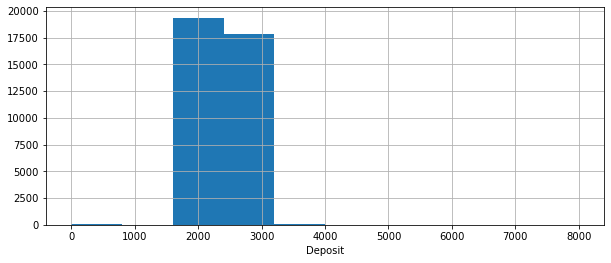

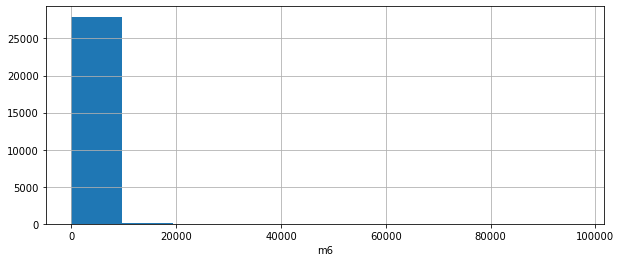

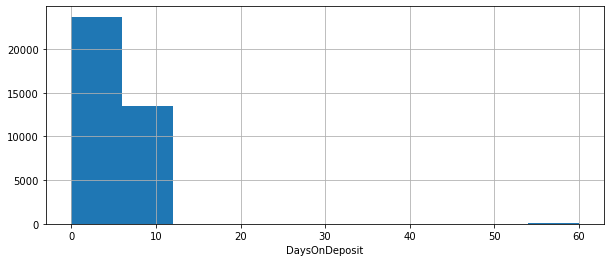

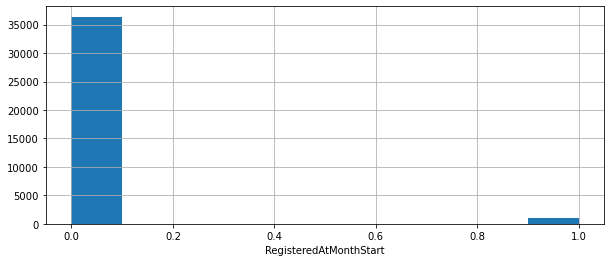

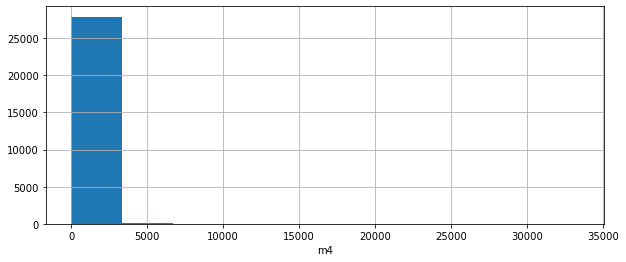

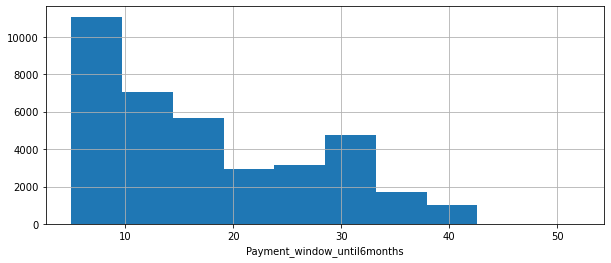

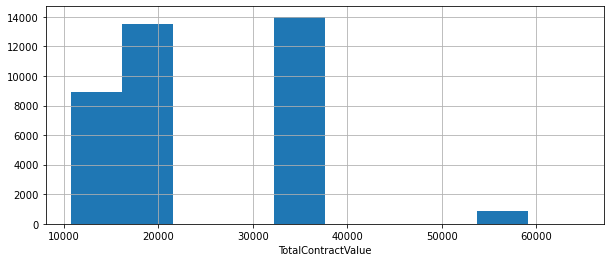

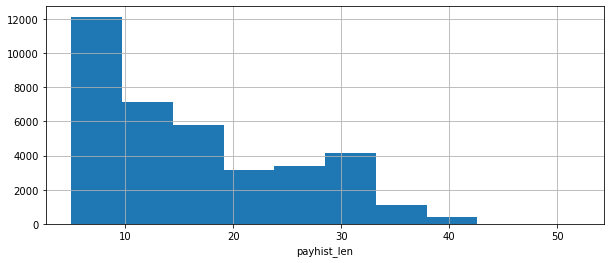

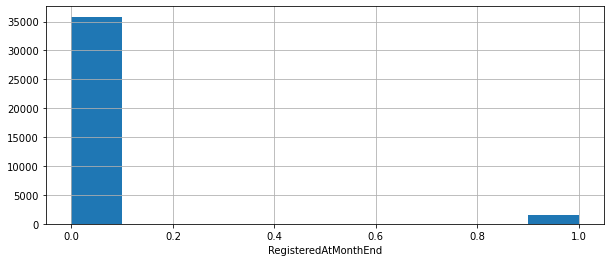

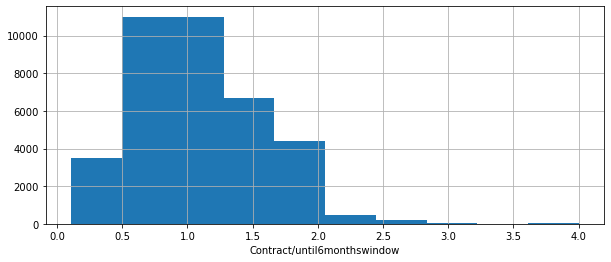

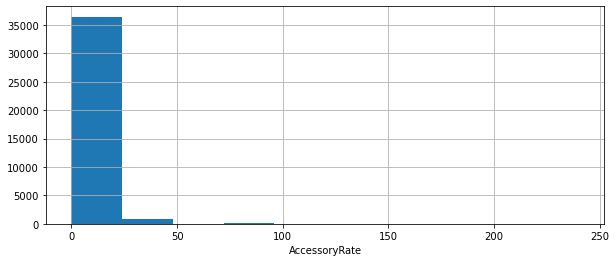

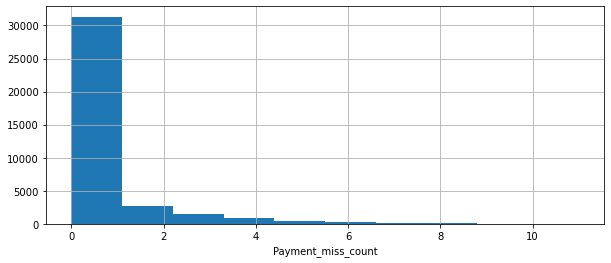

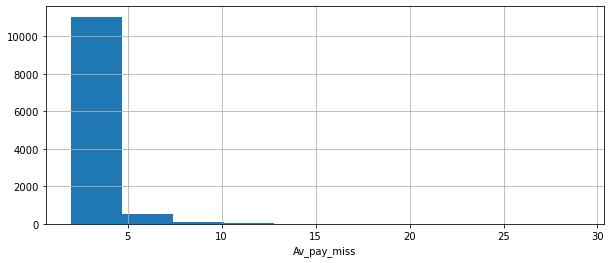

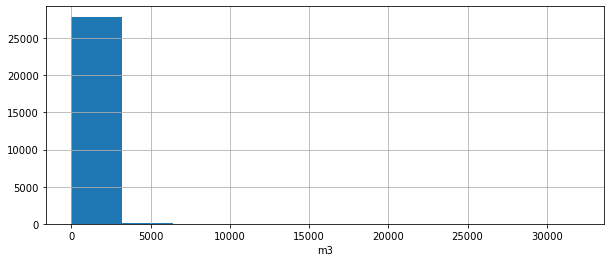

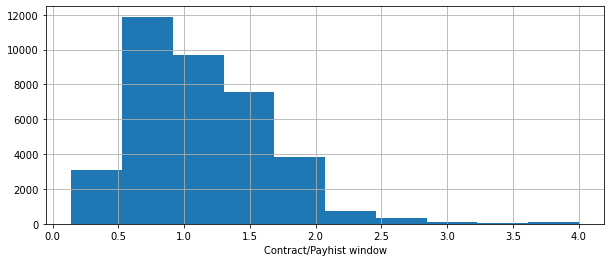

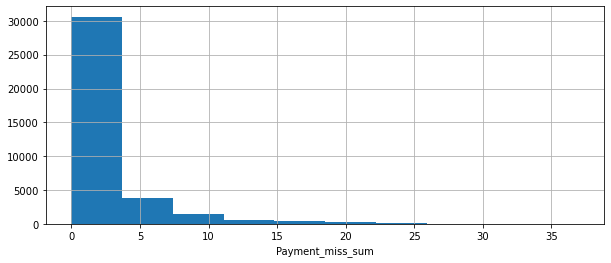

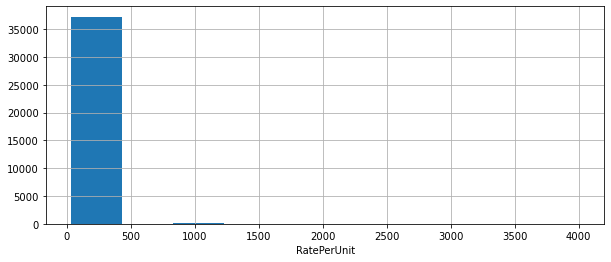

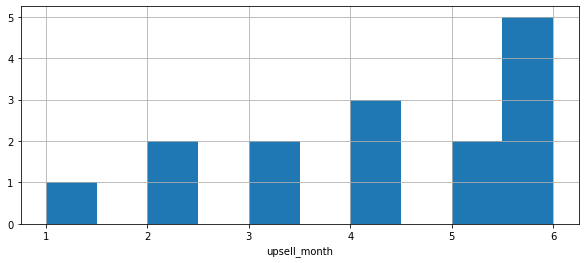

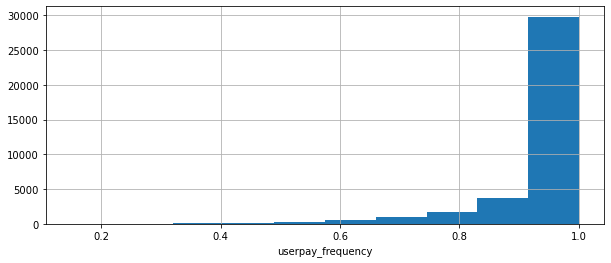

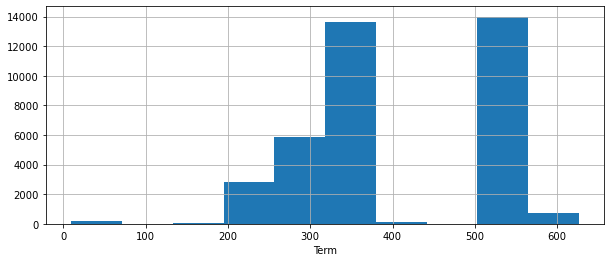

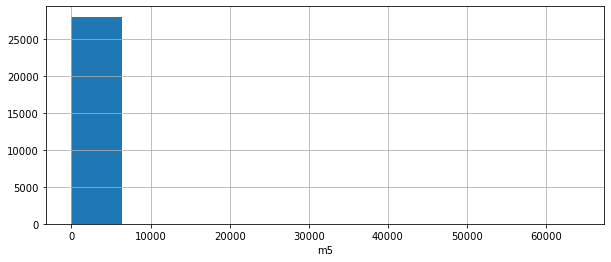

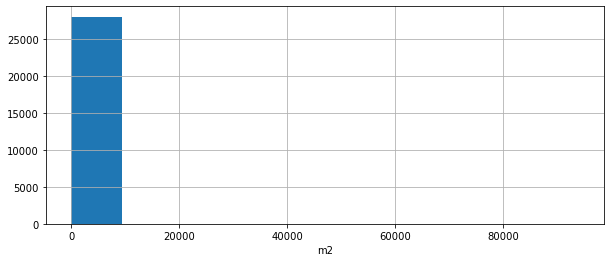

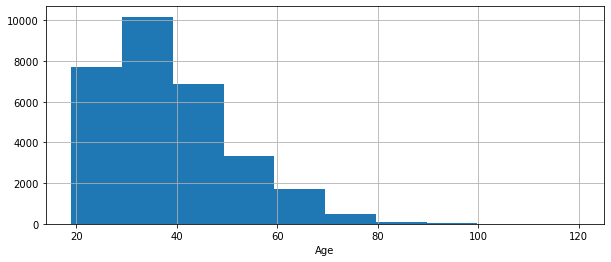

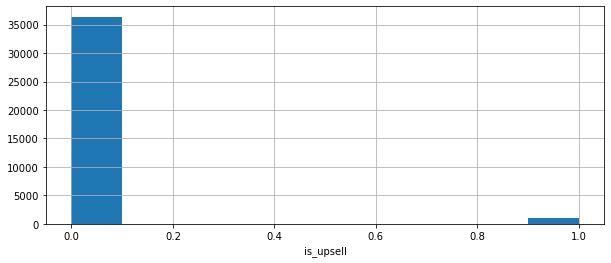

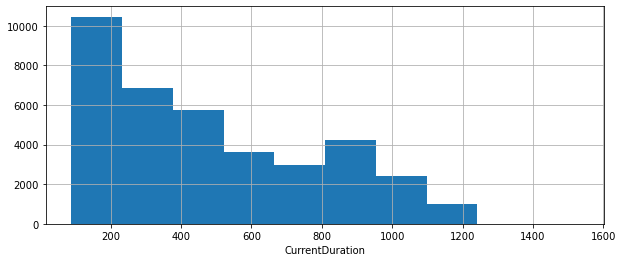

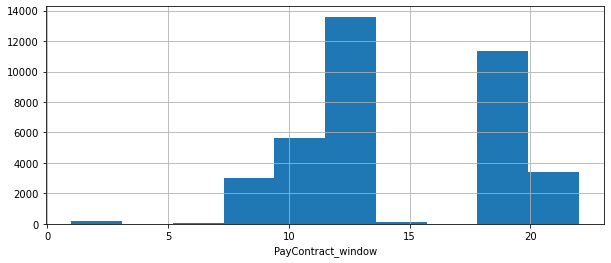

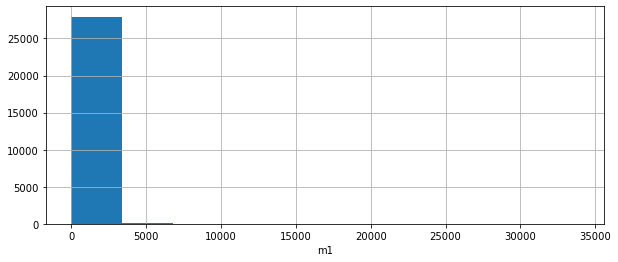

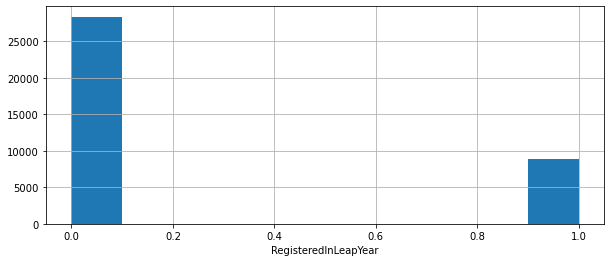

In [106]:
#Numerical histogram of features

for num in num_cols:
    
    merged[num].hist(figsize=(10, 4))
    
    plt.xlabel(num)
    
    plt.show()

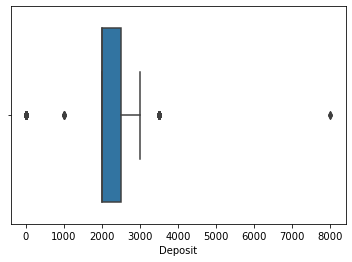

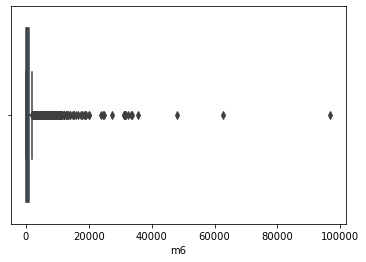

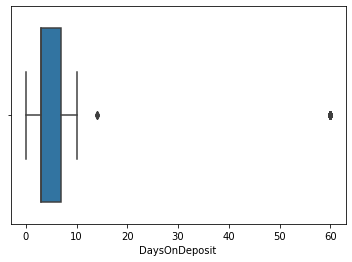

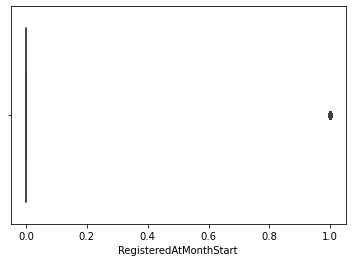

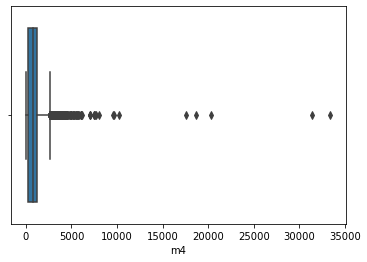

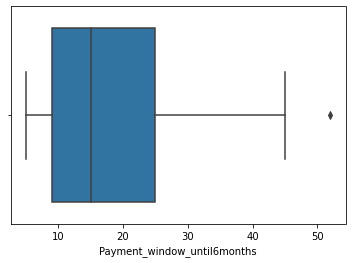

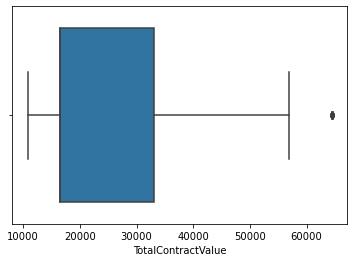

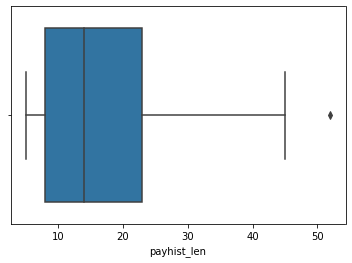

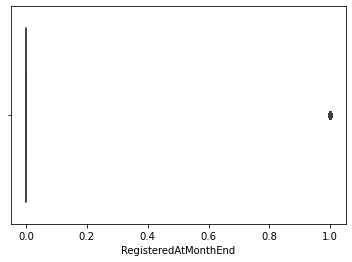

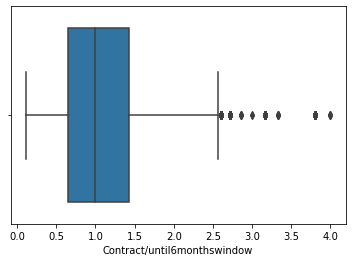

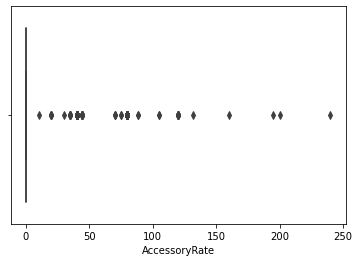

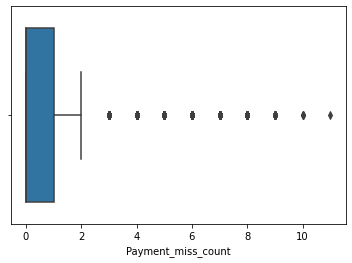

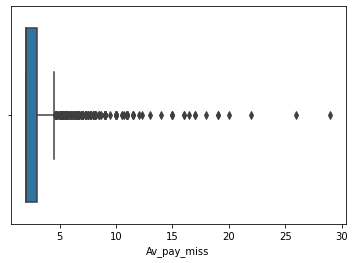

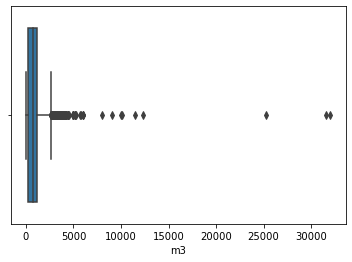

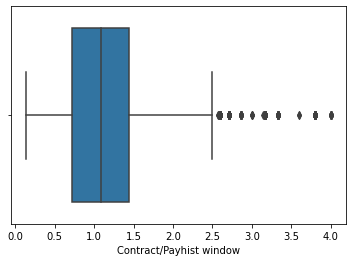

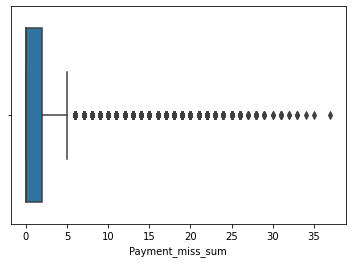

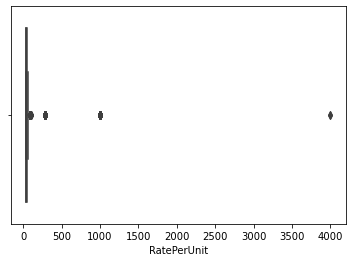

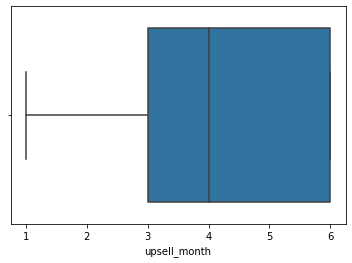

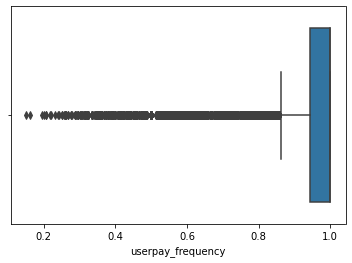

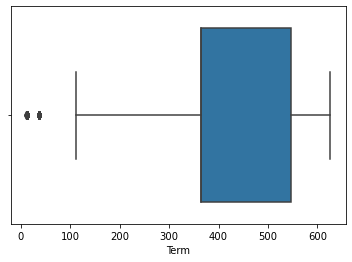

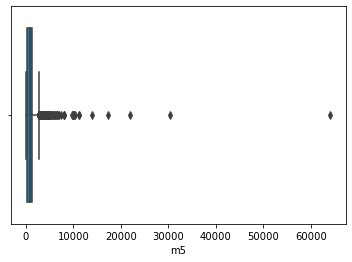

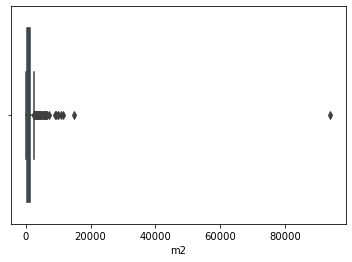

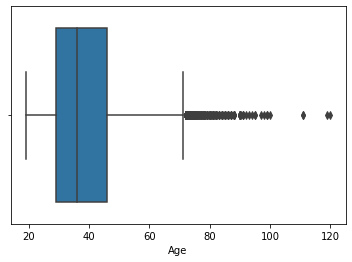

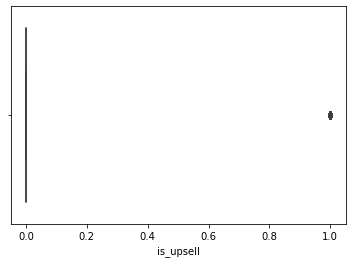

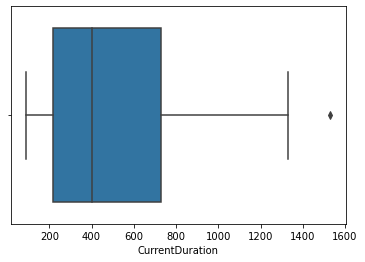

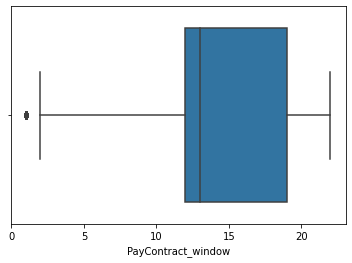

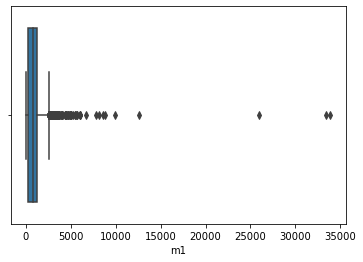

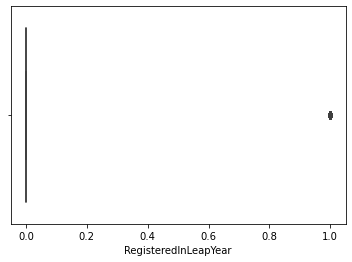

In [107]:
for num in num_cols:
    
    sns.boxplot(merged[num])
    
    plt.show()

***Create Payments History Statistics Features***

In [108]:
payment_df=merged.PaymentsHistory.apply(lambda x:(ast.literal_eval(x)))
transaction_df = merged.TransactionDates.apply(lambda x:(ast.literal_eval(x)))

In [109]:
merged['payment_'+'sum']=payment_df.apply(lambda x:(np.sum(x)))
merged['payment_'+'max']=payment_df.apply(lambda x:(np.max(x)))
merged['payment_'+'mean']=payment_df.apply(lambda x:(np.mean(x)))
merged['payment_'+'median']=payment_df.apply(lambda x:(np.median(x)))
merged['payment_'+'std']=payment_df.apply(lambda x:(np.std(x)))
merged['payment_'+'min']=payment_df.apply(lambda x:(np.min(x)))
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,RegisteredAtMonthEnd,Payment_miss_count,Payment_miss_sum,Av_pay_miss,payment_sum,payment_max,payment_mean,payment_median,payment_std,payment_min
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,0.0,1,2,2.000000,16035.0,3600.0,517.258065,350.0,641.882814,55.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,0.0,1,3,3.000000,22136.0,2940.0,737.866667,655.0,444.435727,380.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,0.0,0,0,NaN,6760.0,2850.0,1126.666667,980.0,917.726660,200.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,0.0,0,0,NaN,11260.0,2200.0,1126.000000,1140.0,485.060821,380.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,0.0,3,8,2.666667,7779.0,2640.0,353.590909,190.0,546.378046,40.0


In [110]:
#Last 5 payments Pattern(from experimentation, the last 5 is most important for predicting next 6 payments)

for i in list(range(-5, 0)):
    
    payment = payment_df.apply(lambda x:x[i])
    
    month_dates = transaction_df.apply(lambda x:x[i])
    
    month_dates = pd.to_datetime(month_dates).dt.month
    
    
    
    pos = 6 + i

    merged['paymenthist_' + 'month ' + str(abs(pos))] = payment
    
    merged['monthshist_' + 'month ' + str(abs(pos))] = month_dates

In [111]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'tag', 'RegistrationDate', 'Deposit',
       'UpsellDate', 'AccessoryRate', 'PaymentMethod', 'rateTypeEntity',
       'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender', 'Age', 'Region',
       'Town', 'Occupation', 'SupplierName', 'Term', 'TotalContractValue',
       'ExpectedTermDate', 'FirstPaymentDate', 'LastTransactionDate',
       'Date m1', 'Date m2', 'Date m3', 'Date m4', 'Date m5', 'Date m6',
       'Payment_window_until6months', 'userpay_frequency',
       'PayContract_window', 'Contract/until6monthswindow',
       'Contract/Payhist window', 'CurrentDuration', 'TermDatetoLastPayment',
       'TermDateto_Date m1', 'TermDateto_Date m2', 'TermDateto_Date m3',
       'TermDateto_Date m4', 'TermDateto_Date m5', 'TermDateto_Date m6',
       'TermDatetoLastPayment/TermDateto_Date m1',
       'TermDatetoLastPayment/TermDateto_Date m2',
       'TermDatetoLastPayment/TermDat

In [112]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,paymenthist_month 1,monthshist_month 1,paymenthist_month 2,monthshist_month 2,paymenthist_month 3,monthshist_month 3,paymenthist_month 4,monthshist_month 4,paymenthist_month 5,monthshist_month 5
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,660.0,7,1200.0,8,1320.0,9,280.0,10,770.0,11
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,605.0,7,660.0,8,660.0,9,655.0,10,770.0,11
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,1500.0,3,1350.0,4,610.0,5,200.0,6,250.0,7
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,780.0,2,1300.0,3,1100.0,4,600.0,5,380.0,6
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,80.0,7,40.0,8,40.0,9,80.0,10,520.0,11


In [113]:
transactions_df=merged.TransactionDates.apply(lambda x:(ast.literal_eval(x)))

In [114]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len', 'tag', 'RegistrationDate', 'Deposit',
       'UpsellDate', 'AccessoryRate', 'PaymentMethod', 'rateTypeEntity',
       'RatePerUnit', 'DaysOnDeposit', 'MainApplicantGender', 'Age', 'Region',
       'Town', 'Occupation', 'SupplierName', 'Term', 'TotalContractValue',
       'ExpectedTermDate', 'FirstPaymentDate', 'LastTransactionDate',
       'Date m1', 'Date m2', 'Date m3', 'Date m4', 'Date m5', 'Date m6',
       'Payment_window_until6months', 'userpay_frequency',
       'PayContract_window', 'Contract/until6monthswindow',
       'Contract/Payhist window', 'CurrentDuration', 'TermDatetoLastPayment',
       'TermDateto_Date m1', 'TermDateto_Date m2', 'TermDateto_Date m3',
       'TermDateto_Date m4', 'TermDateto_Date m5', 'TermDateto_Date m6',
       'TermDatetoLastPayment/TermDateto_Date m1',
       'TermDatetoLastPayment/TermDateto_Date m2',
       'TermDatetoLastPayment/TermDat

**Extracting Historical User Payment Statistics for the month of m1-m6 (For the month where m1-m6, what has been the users historical payemnt pattern**

In [115]:
def extract_payments_month(df, month_m):
    
    months = list()
    
    df['TransactionDates'] = ast.literal_eval( df['TransactionDates'])
    
    index = str(df[month_m]) + '-'
    
    
    for i in range(len(df['TransactionDates'])):
        
        if index in df['TransactionDates'][i]:
            
            months.append(i)
            
            
    payments = ast.literal_eval(df['PaymentsHistory'])
    
    payment_list= [payments[month] for month in months]
    
    
    if len(payment_list) > 0:
        
        median = np.median(payment_list)
    
        std = np.std(payment_list)
    
        minn = np.min(payment_list)
    
        maxx = np.max(payment_list)
    
        meann = np.mean(payment_list)
        
        summ = np.sum(payment_list)
        
        lent = len(payment_list)
        
    
    else:
        
        median = np.nan
        std = np.nan
        minn = np.nan
        maxx = np.nan
        meann = np.nan
        summ = np.nan
        lent = np.nan
                            
        
            
    return pd.Series([median, meann, minn, maxx, std, summ, lent])

In [116]:
for month, month_m in tqdm(zip(['m1', 'm2', 'm3', 'm4', 'm5', 'm6'], ['Date m1 month', 'Date m2 month','Date m3 month', \
                           'Date m4 month', 'Date m5 month', 'Date m6 month'])):
    
    merged[['paymentmedian_' + month, 'paymentmean_' + month,  'paymentmin_' + month, 'paymentmax_' + month, \
            'paymentstd_' + month, 'paymentsum_' + month, 'paymentlen_' + month]]= \
    merged.apply(extract_payments_month, axis = 1, args = [month_m])                     
                         
                         
                         
                         
    
    




6it [03:24, 34.04s/it]


**Extracting Historical User Payment Statistics for the year of m1-m6- Historical payemnt statistics for the year**

In [117]:
def extract_payments_year(df, month_m):
    
    months = list()
    
    df['TransactionDates'] = ast.literal_eval( df['TransactionDates'])
    
    index = str(df[month_m])
    
    for i in range(len(df['TransactionDates'])):
        
        if index in df['TransactionDates'][i]:
            
            months.append(i)
            
    payments = ast.literal_eval(df['PaymentsHistory'])
    
    payment_list= [payments[month] for month in months]
    
    if len(payment_list) > 0:
        
        median = np.median(payment_list)
    
        std = np.std(payment_list)
    
        minn = np.min(payment_list)
    
        maxx = np.max(payment_list)
    
        meann = np.mean(payment_list)
        
        summ = np.sum(payment_list)
        
        lent = len(payment_list)
        
    else:
        
        median = np.nan
        std = np.nan
        minn = np.nan
        maxx = np.nan
        meann = np.nan
        summ = np.nan
        lent = np.nan
                            
        
            
    return pd.Series([median, meann, minn, maxx, std, summ, lent])

In [118]:
for month, month_m in tqdm(zip(['m1', 'm2', 'm3', 'm4', 'm5', 'm6'], ['Date m1 year', 'Date m2 year','Date m3 year', \
                           'Date m4 year', 'Date m5 year', 'Date m6 year'])):
    
    merged[['paymentmedianyr_' + month, 'paymentmeanyr_' + month,  'paymentminyr_' + month, 'paymentmaxyr_' + month, \
            'paymentstdyr_' + month, 'paymentsumyr_' + month, 'paymentlenyr_' + month]]= \
    merged.apply(extract_payments_year, axis = 1, args = [month_m])                     
                         
                         
                     

6it [03:18, 33.09s/it]


In [119]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,paymentstdyr_m5,paymentsumyr_m5,paymentlenyr_m5,paymentmedianyr_m6,paymentmeanyr_m6,paymentminyr_m6,paymentmaxyr_m6,paymentstdyr_m6,paymentsumyr_m6,paymentlenyr_m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,917.726660,6760.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,369.804753,5560.0,6.0,940.0,926.666667,380.0,1400.0,369.804753,5560.0,6.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Extract First Payment Amount from Transaction History**

In [120]:
merged['First_payment'] =  payment_df.apply(lambda x : x[0])

In [121]:
merged['First_payment']

0        3600.0
1        2940.0
2        2850.0
3        2200.0
4        2640.0
          ...  
37338    2690.0
37339    2950.0
37340    2550.0
37341    2700.0
37342    2300.0
Name: First_payment, Length: 37343, dtype: float64

***Analysis- What does TotalContractValue mean? Related to the total value of a package. Does sum(m1-m6) and PaymentsHistory match TotalContractValue***

In [122]:
(merged['TotalContractValue']/ (merged['payment_sum'] + merged['m1'] + merged['m2'] + \
                                merged['m3'] + merged['m4'] + merged['m5'] + merged['m6'])).value_counts()

1.000000    11196
0.999970      261
0.996885      193
0.997590      154
0.999396      136
            ...  
0.988244        1
1.231262        1
4.688776        1
1.254287        1
1.819802        1
Length: 9417, dtype: int64

Majority of m1-m6 & Payment Sum equals Total Contract Value. Create new feature for fraction of payments settled towards Total Contract Value

***Set label for customers who overpaid***

In [123]:
# some customers seem to have ovrpaid ie their total payments is greater than the contract value
merged['overpaid'] = (merged.payment_sum > merged.TotalContractValue) * 1

***Create payment left feature***

In [124]:
#total amount left to pay. if difference b/w contract value and totalpayment is negative, 
# bin to zero indicating no outstanding payments
merged['payLeft'] = (merged.TotalContractValue - merged.payment_sum)

merged['payLeft'][merged['payLeft'] < 0] = 0

In [125]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,paymentmedianyr_m6,paymentmeanyr_m6,paymentminyr_m6,paymentmaxyr_m6,paymentstdyr_m6,paymentsumyr_m6,paymentlenyr_m6,First_payment,overpaid,payLeft
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,0,17045.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2940.0,0,10944.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2850.0,0,7640.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,940.0,926.666667,380.0,1400.0,369.804753,5560.0,6.0,2200.0,0,5300.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2640.0,0,8781.0


***Create feature on total payments made within the contract***

In [126]:
def TotalAmountsPaidWithinContract(df):
    """Returns a dataframe with the total amounts paid by a customer within the expected contract tenure
    
    :param df : Pandas DataFrame
    :returns Total Amount Paid by Customer on or before contract tenure 
    """
    for i, row in df[['ExpectedTermDate', 'TransactionDates', 'PaymentsHistory', 'Deposit']].iterrows():
        expected_month_yr = np.array(row.ExpectedTermDate.strftime('%Y-%m'))
        transactions = literal_eval(row.TransactionDates)
        paymentsHist = literal_eval(row.PaymentsHistory)
        
        # has the customer renewed contract? Get how many months paid on or before contract tenure
        month_paid_b4_contract = len(np.where(expected_month_yr >= transactions)[0])

        if month_paid_b4_contract > 0:
            df.loc[i, 'Tot_Amt_by_contractTenure'] = sum(paymentsHist[:month_paid_b4_contract])
        else:
            df.loc[i, 'Tot_Amt_by_contractTenure'] = sum(paymentsHist)
    return df

In [127]:
merged = TotalAmountsPaidWithinContract(merged)

***Create payment proportion to TotalContractValue & Ratio of Total Contract to the Term in terms of expected static payments daily***

In [128]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,paymentmeanyr_m6,paymentminyr_m6,paymentmaxyr_m6,paymentstdyr_m6,paymentsumyr_m6,paymentlenyr_m6,First_payment,overpaid,payLeft,Tot_Amt_by_contractTenure
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,NaN,NaN,NaN,NaN,NaN,NaN,3600.0,0,17045.0,16035.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,2940.0,0,10944.0,22136.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,2850.0,0,7640.0,6760.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,926.666667,380.0,1400.0,369.804753,5560.0,6.0,2200.0,0,5300.0,11260.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,NaN,NaN,NaN,NaN,NaN,NaN,2640.0,0,8781.0,7779.0


In [129]:
merged['payedsum/TotalContract'] = merged['payment_sum']/merged['TotalContractValue']

merged['TotalContract/Term'] = merged['TotalContractValue'] / merged['Term']

In [130]:
merged['ContractRate_month'] = (merged.TotalContractValue/(pd.to_timedelta(merged.Term, unit = 'D')/ np.timedelta64(1, 'M')))

In [131]:
# ratio btw expected month payments and average monthly payments of customer
merged['Contract_Rate_vs_Average_pay'] = merged.ContractRate_month / merged.payment_mean

In [132]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,paymentsumyr_m6,paymentlenyr_m6,First_payment,overpaid,payLeft,Tot_Amt_by_contractTenure,payedsum/TotalContract,TotalContract/Term,ContractRate_month,Contract_Rate_vs_Average_pay
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,NaN,NaN,3600.0,0,17045.0,16035.0,0.484734,59.496403,1810.884577,3.500931
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,NaN,NaN,2940.0,0,10944.0,22136.0,0.669166,59.496403,1810.884577,2.454217
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,NaN,NaN,2850.0,0,7640.0,6760.0,0.469444,60.000000,1826.212500,1.620899
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,5560.0,6.0,2200.0,0,5300.0,11260.0,0.679952,45.494505,1384.710577,1.229761
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,NaN,NaN,2640.0,0,8781.0,7779.0,0.469746,45.494505,1384.710577,3.916137


***Analysis- How is the Age group related to Payment Amounts***

In [133]:
def create_age_group(age):

    if age in list(range(18, 22)):
        
        return '18-21'
    
    elif age in list(range(22, 30)):
        
        return '22-29'
    
    elif age in list(range(30, 41)):
        
        return '30-40'
    
    elif age in list(range(41, 51)):
        
        return '41-50'
    
    elif age in list(range(51, 65)):
        
        return '51-64'
    
    elif age > 64:
        
        return '65+'
    

    


In [134]:
merged['age_group'] = merged['Age'].apply(create_age_group)

In [135]:
merged[['Age', 'age_group']].isnull().sum()

Age          6939
age_group    6939
dtype: int64

In [136]:
merged.columns[60:100]

Index(['Date m2 year', 'Date m3 month', 'Date m3 year', 'Date m4 month',
       'Date m4 year', 'Date m5 month', 'Date m5 year', 'Date m6 month',
       'Date m6 year', 'RegistrationDate month', 'RegistrationDate year',
       'RegistrationDate day', 'LastTransactionDate month',
       'LastTransactionDate year', 'LastTransactionDate day',
       'FirstPaymentDate month', 'FirstPaymentDate year',
       'FirstPaymentDate day', 'RegisteredInLeapYear',
       'RegisteredAtMonthStart', 'RegisteredAtMonthEnd', 'Payment_miss_count',
       'Payment_miss_sum', 'Av_pay_miss', 'payment_sum', 'payment_max',
       'payment_mean', 'payment_median', 'payment_std', 'payment_min',
       'paymenthist_month 1', 'monthshist_month 1', 'paymenthist_month 2',
       'monthshist_month 2', 'paymenthist_month 3', 'monthshist_month 3',
       'paymenthist_month 4', 'monthshist_month 4', 'paymenthist_month 5',
       'monthshist_month 5'],
      dtype='object')

***Create PaymentHistory Statistics by Age group***

In [137]:
def cat_payment_stats(col):
    
    for i in ['payment_mean', 'payment_median', 'payment_sum', 'payment_std', 'payment_min', 'payment_max']:
        
        merged[col + '_ ' + i]= merged[col].map(merged.groupby(col)[i].median())
    
    

In [138]:
cat_payment_stats('age_group')

In [139]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len',
       ...
       'TotalContract/Term', 'ContractRate_month',
       'Contract_Rate_vs_Average_pay', 'age_group', 'age_group_ payment_mean',
       'age_group_ payment_median', 'age_group_ payment_sum',
       'age_group_ payment_std', 'age_group_ payment_min',
       'age_group_ payment_max'],
      dtype='object', length=199)

In [140]:
merged.groupby('age_group')['payment_median'].median()

age_group
18-21     900.0
22-29     875.0
30-40     900.0
41-50     950.0
51-64     990.0
65+      1000.0
Name: payment_median, dtype: float64

Seems the younger demographic have lower energy payments spend compared to older demographics. Consider creating payment features based on age groups. Further analysis to be done on the target relationships m1-m6.

In [141]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len',
       ...
       'TotalContract/Term', 'ContractRate_month',
       'Contract_Rate_vs_Average_pay', 'age_group', 'age_group_ payment_mean',
       'age_group_ payment_median', 'age_group_ payment_sum',
       'age_group_ payment_std', 'age_group_ payment_min',
       'age_group_ payment_max'],
      dtype='object', length=199)

***Analysis- What is RatePerUnit***

In [142]:
merged[['RatePerUnit', 'rateTypeEntity', 'payment_min', 'TransactionDates']]

,RatePerUnit,rateTypeEntity,payment_min,TransactionDates
0,55,DAILY,55.0,"['04-2018', '05-2018', '06-2018', '07-2018', '..."
1,55,DAILY,380.0,"['04-2018', '05-2018', '06-2018', '07-2018', '..."
2,50,DAILY,200.0,"['02-2020', '03-2020', '04-2020', '05-2020', '..."
3,40,DAILY,380.0,"['09-2017', '10-2017', '11-2017', '12-2017', '..."
4,40,DAILY,40.0,"['09-2017', '10-2017', '11-2017', '12-2017', '..."
...,...,...,...,...
37338,50,DAILY,270.0,"['02-2020', '03-2020', '04-2020', '05-2020', '..."
37339,50,DAILY,80.0,"['02-2020', '03-2020', '04-2020', '05-2020', '..."
37340,50,DAILY,200.0,"['02-2020', '03-2020', '04-2020', '05-2020', '..."
37341,50,DAILY,150.0,"['02-2020', '03-2020', '04-2020', '05-2020', '..."


According to varable definition, RatePerUnit is Amount needed to generate a token for a minimum credit period specified by the rate type. Some times this amount is related to the minimum payment made by user.

In [143]:
merged['RatePerUnit/pay_min'] = merged['RatePerUnit']/merged['payment_min']

In [144]:
num_cols

['Deposit',
 'm6',
 'DaysOnDeposit',
 'RegisteredAtMonthStart',
 'm4',
 'Payment_window_until6months',
 'TotalContractValue',
 'payhist_len',
 'RegisteredAtMonthEnd',
 'Contract/until6monthswindow',
 'AccessoryRate',
 'Payment_miss_count',
 'Av_pay_miss',
 'm3',
 'Contract/Payhist window',
 'Payment_miss_sum',
 'RatePerUnit',
 'upsell_month',
 'userpay_frequency',
 'Term',
 'm5',
 'm2',
 'Age',
 'is_upsell',
 'CurrentDuration',
 'PayContract_window',
 'm1',
 'RegisteredInLeapYear']

***Analysis- What is the meaning of Accessory rate***

In [145]:
upsell_analyse[['AccessoryRate', 'UpsellDate', 'TransactionDates']]

,AccessoryRate,UpsellDate,TransactionDates
19,70.0,08-2019,"['10-2016', '11-2016', '12-2016', '01-2017', '..."
332,0.0,11-2019,"['03-2018', '04-2018', '05-2018', '06-2018', '..."
1106,0.0,03-2019,"['04-2018', '05-2018', '06-2018', '07-2018', '..."
1453,70.0,08-2019,"['10-2017', '11-2017', '12-2017', '01-2018', '..."
1636,105.0,09-2019,"['09-2016', '10-2016', '11-2016', '12-2016', '..."
1671,0.0,02-2019,"['04-2018', '05-2018', '06-2018', '07-2018', '..."
3253,70.0,09-2019,"['12-2016', '01-2017', '02-2017', '03-2017', '..."
4795,0.0,06-2018,"['03-2018', '04-2018', '05-2018', '06-2018', '..."
6971,0.0,11-2018,"['03-2018', '05-2018', '06-2018', '07-2018', '..."
8604,0.0,09-2018,"['03-2018', '04-2018', '05-2018', '06-2018', '..."


***Analysis- Corrrelation Relationships***

In [146]:
cat_cols, date_cols, num_cols = Column_types()

<AxesSubplot:>

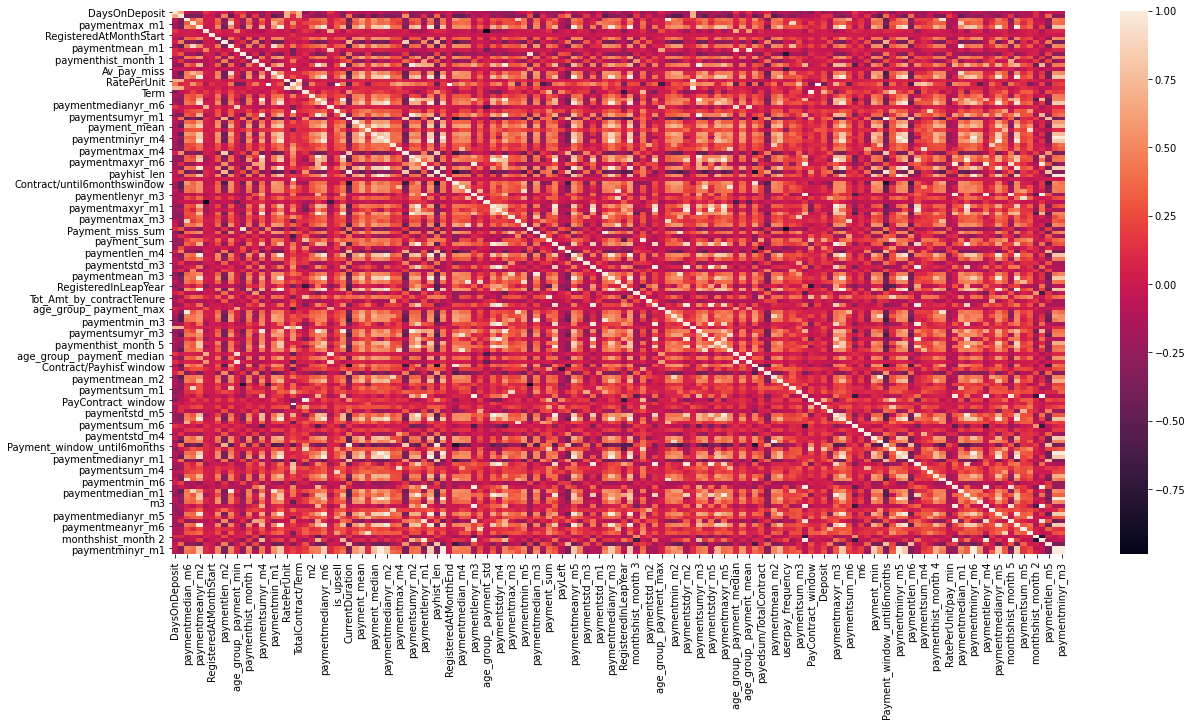

In [147]:
plt.figure(figsize = (20, 10))

sns.heatmap(merged[num_cols].corr())

#### CATEGORICAL

In [148]:
def catplot_distribution(col):
    
    ax = merged[col].value_counts().sort_values().plot(kind = 'barh', figsize=(15, 15))
    plt.title(col + ' Distribution', fontdict={'size': 15})
    
    for p in ax.patches:
        
        percentage ='{:,.2f}%'.format((p.get_width()/merged.shape[0])*100)
        width, height =p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2
        ax.annotate(percentage,(x,y))
        
    
    plt.show()


In [149]:
def payhist_distribution(col):
    
    plt.figure(figsize = (15, 15))

    
    plt.title(col + ' _Median Payment Distribution', fontdict={'size': 15})
    plt.bar(merged.groupby(col)['payment_median'].median().index, \
            merged.groupby(col)['payment_median'].median().values)
    
    plt.xticks(rotation = 90)
    plt.show()

In [150]:
cat_cols.remove('PaymentsHistory')

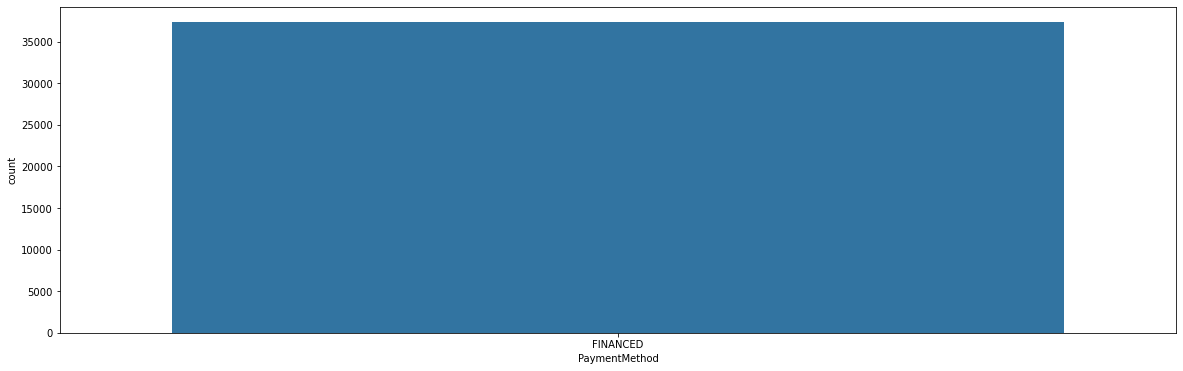

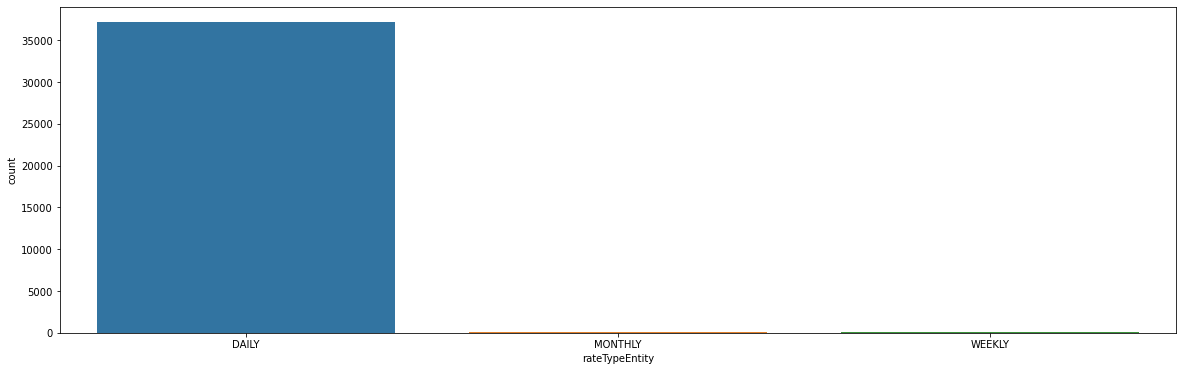

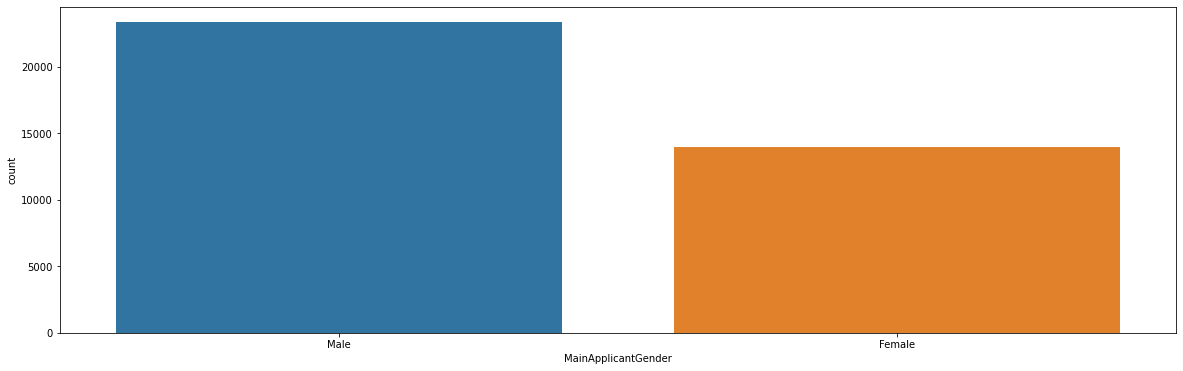

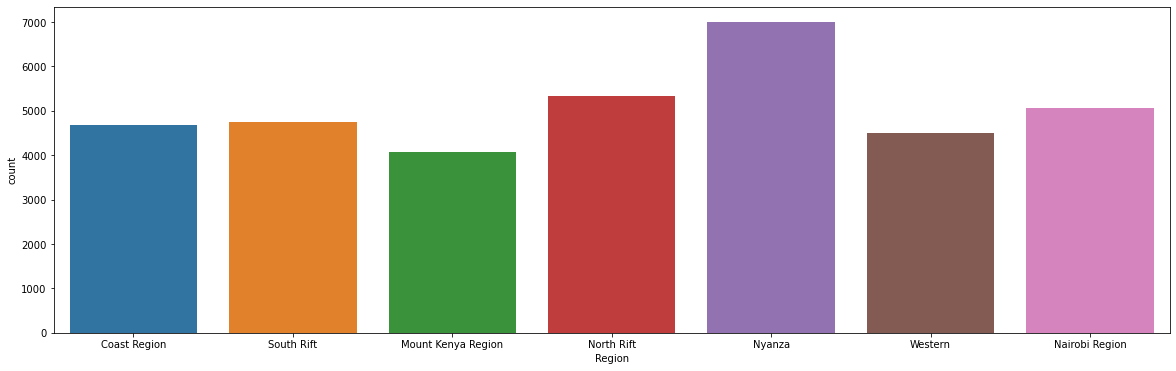

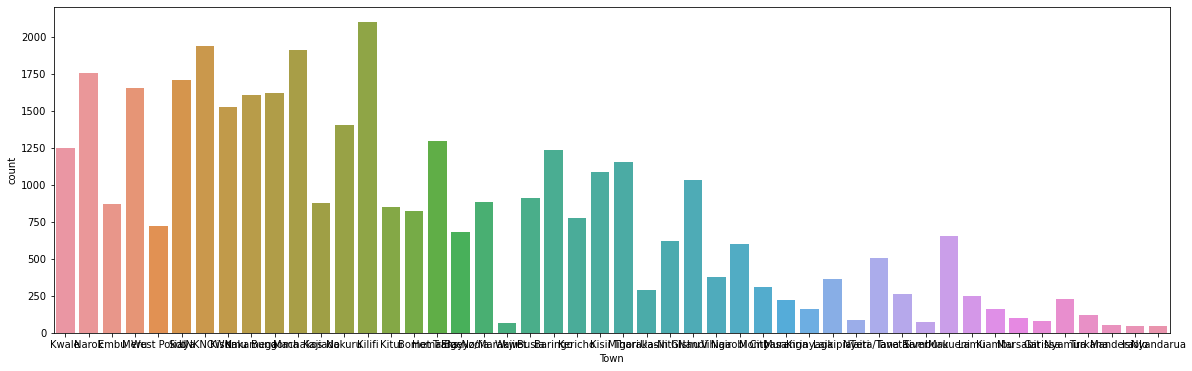

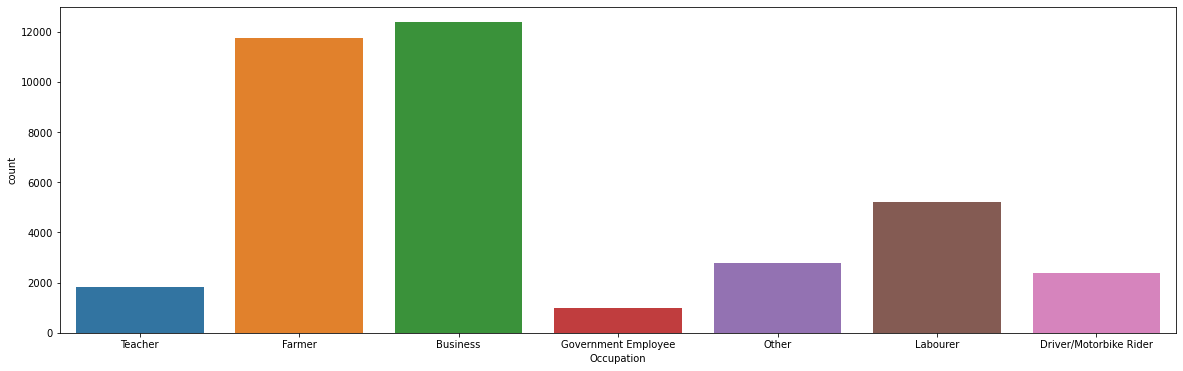

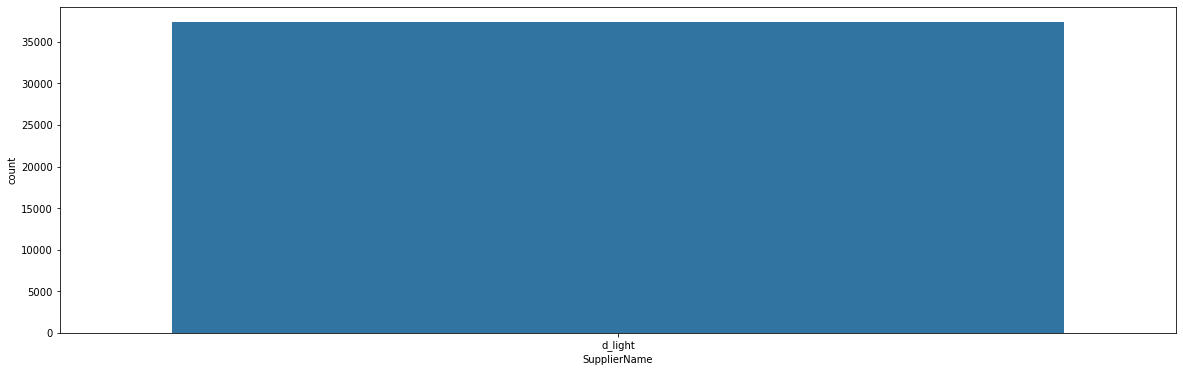

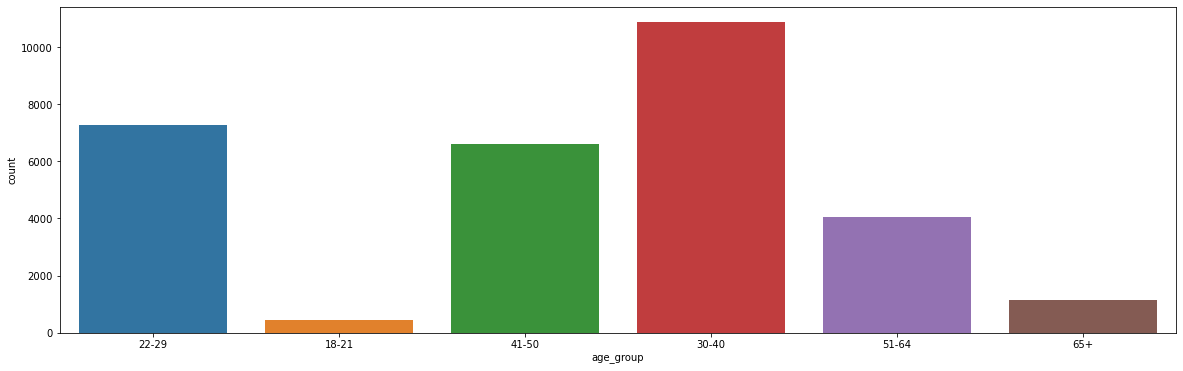

In [151]:
for col in list(cat_cols):
    
    plt.figure(figsize = (20, 6))
    
    sns.countplot(merged[col])
    
    plt.show()

In [152]:
for col in cat_cols:
    
    print(col)
    
    print ('-----' * 10)
    
    print(merged[col].value_counts())
          
    print('-----' * 20)

PaymentMethod
--------------------------------------------------
FINANCED    37343
Name: PaymentMethod, dtype: int64
----------------------------------------------------------------------------------------------------
rateTypeEntity
--------------------------------------------------
DAILY      37168
MONTHLY       97
WEEKLY        78
Name: rateTypeEntity, dtype: int64
----------------------------------------------------------------------------------------------------
MainApplicantGender
--------------------------------------------------
Male      23351
Female    13992
Name: MainApplicantGender, dtype: int64
----------------------------------------------------------------------------------------------------
Region
--------------------------------------------------
Nyanza                6998
North Rift            5344
Nairobi Region        5056
South Rift            4759
Coast Region          4671
Western               4508
Mount Kenya Region    4073
Name: Region, dtype: int64
-----------

Constant features Payment Method and Supplier Name

In [153]:
merged = merged.drop(['SupplierName', 'PaymentMethod'], axis = 1)

In [154]:
cat_cols, date_cols, num_cols = Column_types()

***Analysis- Explore Occupation***

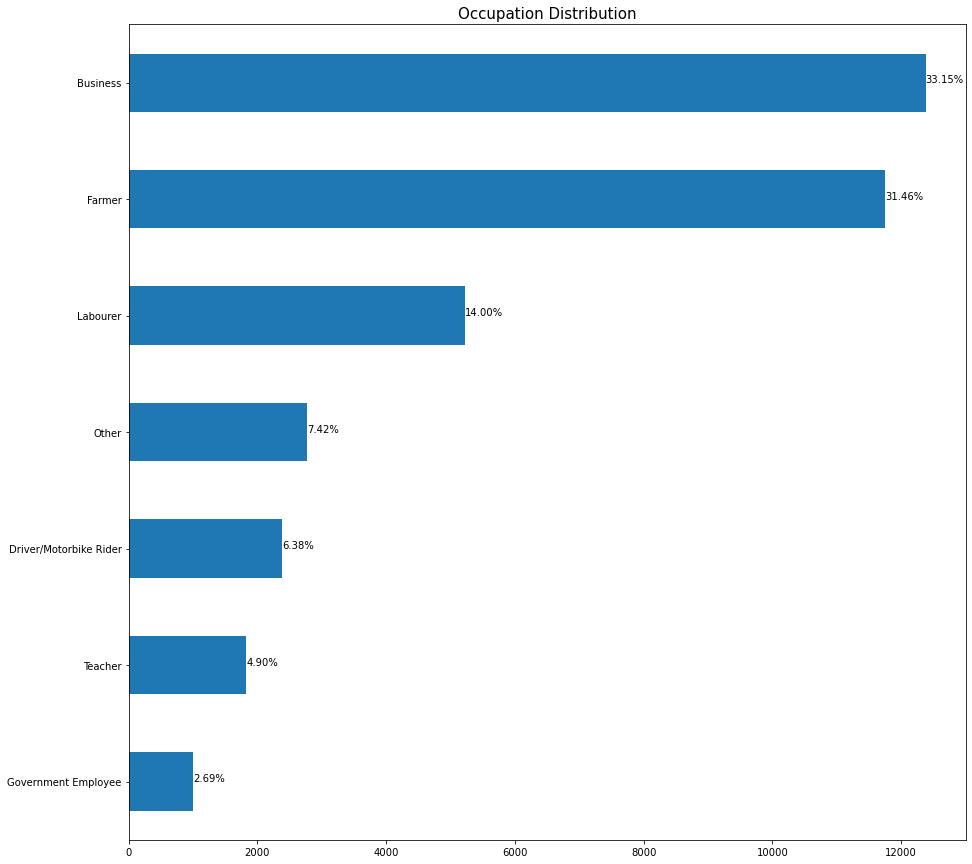

In [155]:
# Occupation distribution 
catplot_distribution('Occupation')

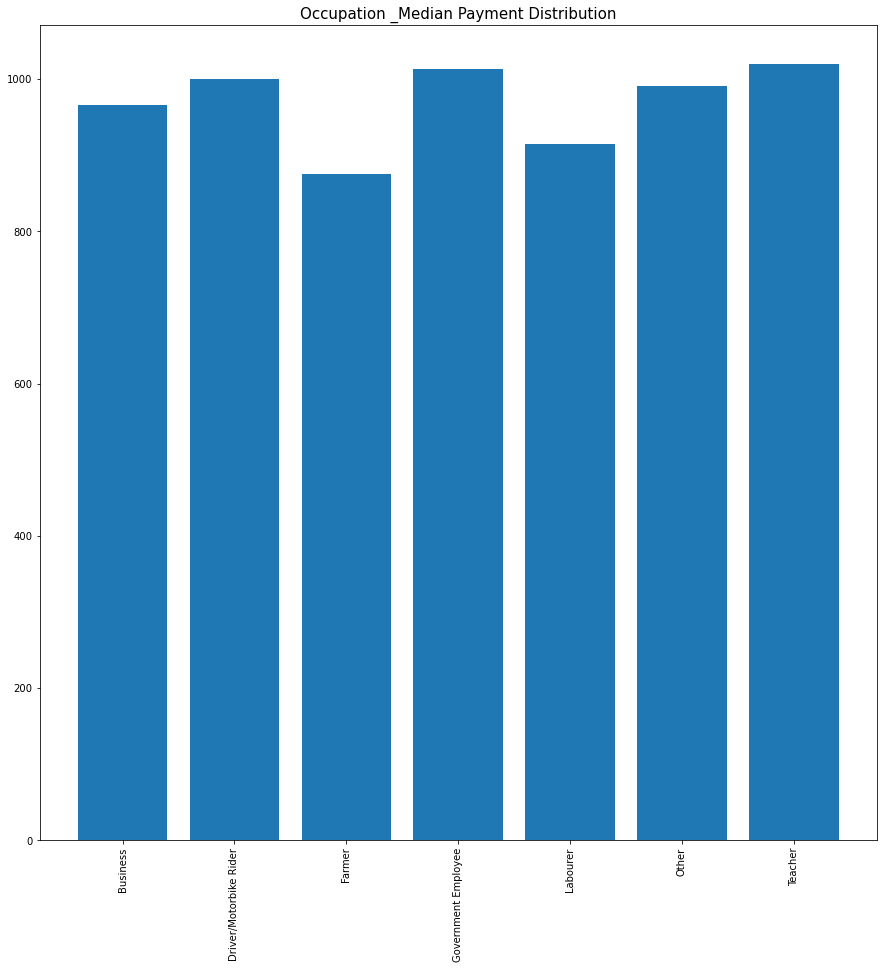

In [156]:
payhist_distribution('Occupation')

***Create PaymentHistory Statistics by Occupation***

In [157]:
cat_payment_stats('Occupation')

***Analysis- Explore Region & Town***

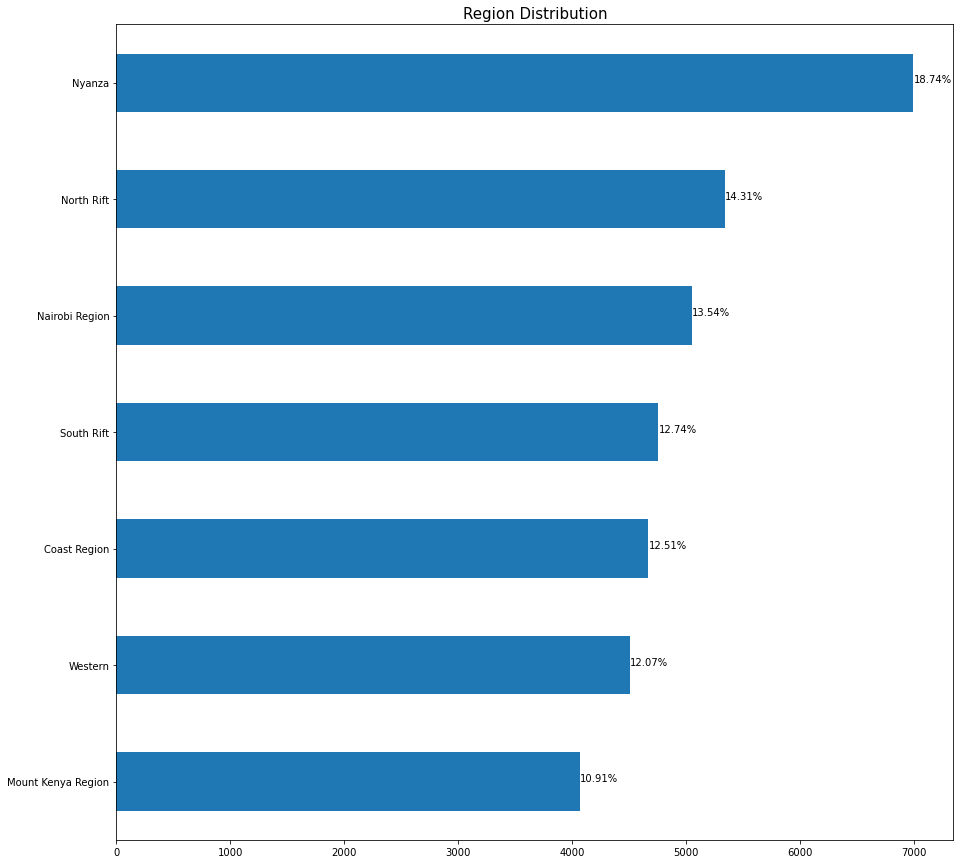

In [158]:
# Region distribution 
catplot_distribution('Region')

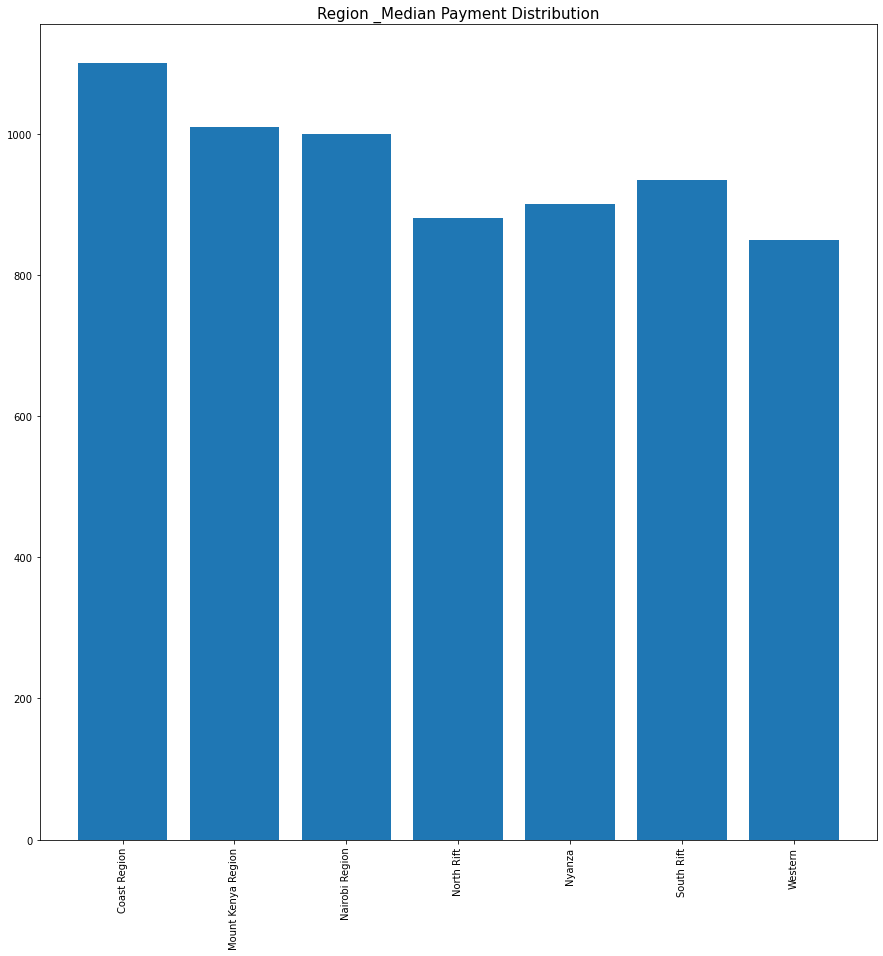

In [159]:
payhist_distribution('Region')

In [160]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,age_group_ payment_std,age_group_ payment_min,age_group_ payment_max,RatePerUnit/pay_min,Occupation_ payment_mean,Occupation_ payment_median,Occupation_ payment_sum,Occupation_ payment_std,Occupation_ payment_min,Occupation_ payment_max
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,NaN,NaN,NaN,1.000000,1153.950000,1020.0,12810.0,655.525344,293.0,3000.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,639.569543,200.0,2800.0,0.144737,985.354839,875.0,11990.0,597.624929,200.0,2880.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,710.924698,325.0,2800.0,0.250000,1076.775641,966.0,11320.0,610.149339,270.0,2850.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,639.569543,200.0,2800.0,0.105263,985.354839,875.0,11990.0,597.624929,200.0,2880.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,639.569543,200.0,2800.0,1.000000,985.354839,875.0,11990.0,597.624929,200.0,2880.0


In [161]:
merged[['Region', 'Town']].isnull().sum()

Region    1934
Town         0
dtype: int64

There are Regions with no data but Town has some data. Explore

In [162]:
merged[merged['Region'].isnull() == True]['Town'].value_counts()

UNKNOWN    1934
Name: Town, dtype: int64

In [163]:
merged.loc[merged['Town'] == 'UNKNOWN', 'Town'] = np.nan

In [164]:
merged[['Region', 'Town']].isnull().sum()

Region    1934
Town      1934
dtype: int64

***Create PaymentHistory Statistics by Region***

In [165]:
cat_payment_stats('Region')

In [166]:
merged.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,...,Occupation_ payment_sum,Occupation_ payment_std,Occupation_ payment_min,Occupation_ payment_max,Region_ payment_mean,Region_ payment_median,Region_ payment_sum,Region_ payment_std,Region_ payment_min,Region_ payment_max
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,...,12810.0,655.525344,293.0,3000.0,1221.428571,1100.0,22580.0,652.399418,335.0,3220.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,...,11990.0,597.624929,200.0,2880.0,1054.000000,935.0,13000.0,614.635021,240.0,3000.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,...,11320.0,610.149339,270.0,2850.0,1143.076923,1010.0,11770.0,620.799997,330.0,2940.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,...,11990.0,597.624929,200.0,2880.0,1143.076923,1010.0,11770.0,620.799997,330.0,2940.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,...,11990.0,597.624929,200.0,2880.0,990.000000,880.0,11460.5,592.652439,240.0,2800.0


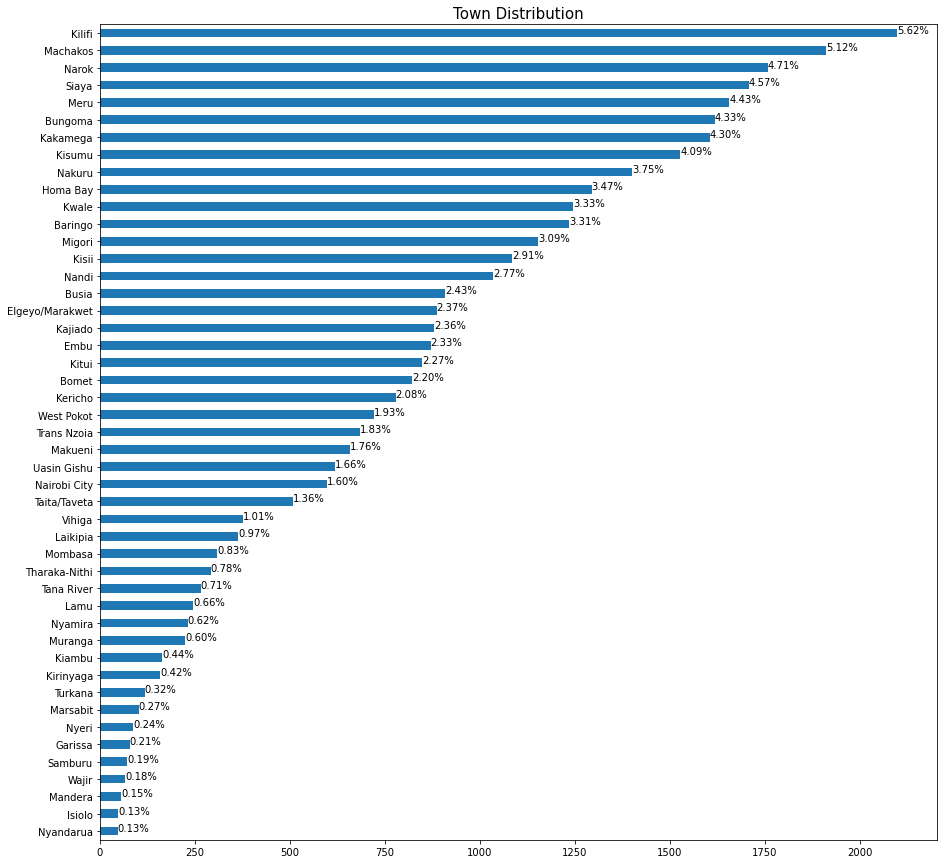

In [167]:
# Region distribution 
catplot_distribution('Town')

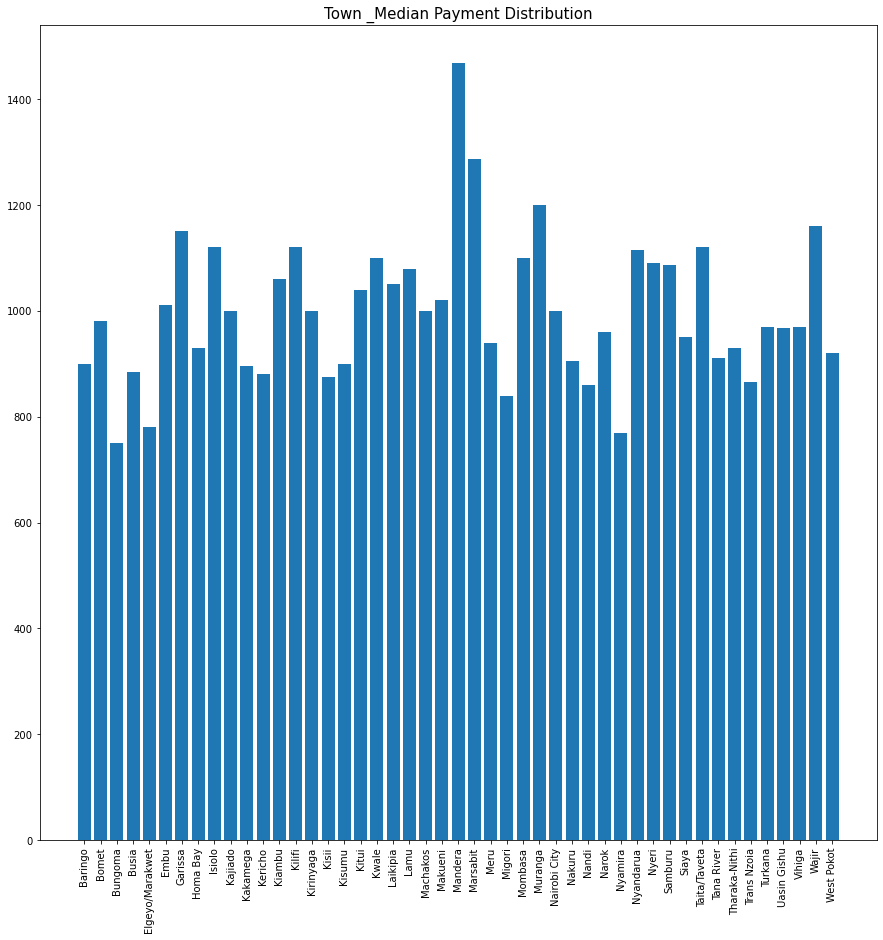

In [168]:
payhist_distribution('Town')

***Create PaymentHistory Statistics by Town***

In [169]:
cat_payment_stats('Town')

In [170]:
merged[['Town_ payment_mean', 'Town_ payment_median', 'Town_ payment_sum',
       'Town_ payment_std', 'Town_ payment_min', 'Town_ payment_max']]

,Town_ payment_mean,Town_ payment_median,Town_ payment_sum,Town_ payment_std,Town_ payment_min,Town_ payment_max
0,1181.117647,1100.00,23904.0,636.062890,300.0,3274.0
1,1074.714815,960.00,21287.5,621.276697,257.5,3200.0
2,1158.349462,1011.75,11345.0,624.201124,400.0,2840.0
3,1023.262626,940.00,13086.0,577.415253,250.0,2900.0
4,1001.250000,920.00,13910.0,601.748117,220.0,3000.0
...,...,...,...,...,...,...
37338,980.769231,875.00,12620.0,623.169638,165.0,3000.0
37339,1248.444444,1120.00,23574.5,646.338941,370.0,3302.5
37340,999.310345,900.00,12295.0,578.833274,250.0,2790.0
37341,1049.207692,930.00,12825.0,614.469029,265.0,2999.0


***Analysis- Rate type entity***

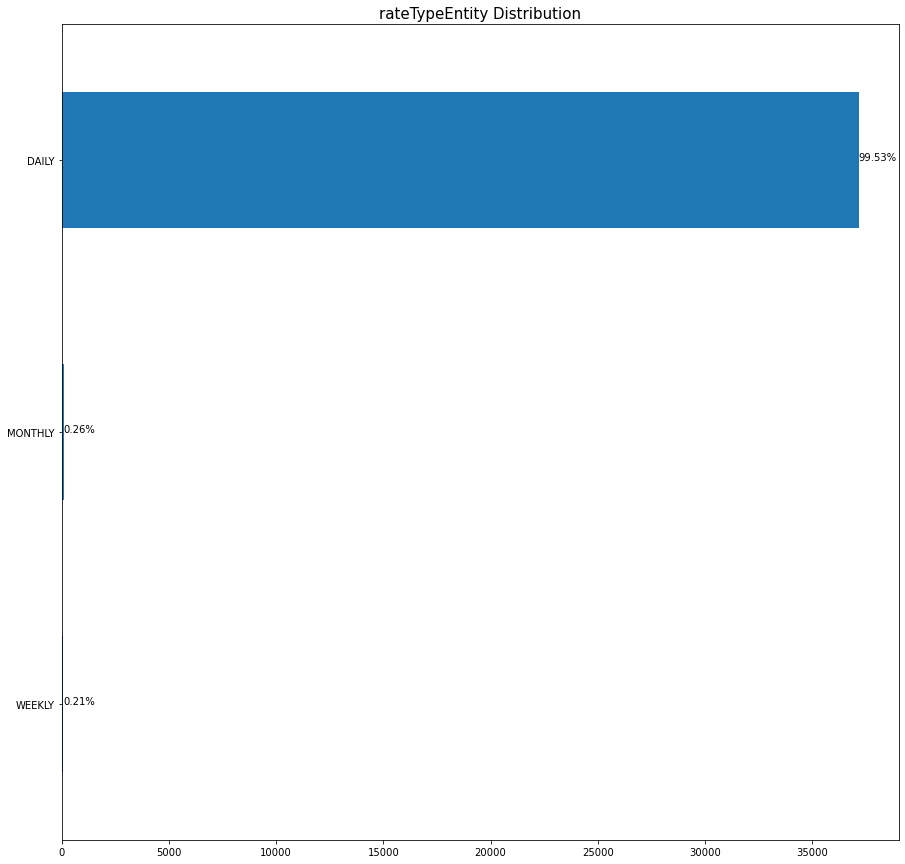

In [171]:
# Rate Type Entity distribution 
catplot_distribution('rateTypeEntity')

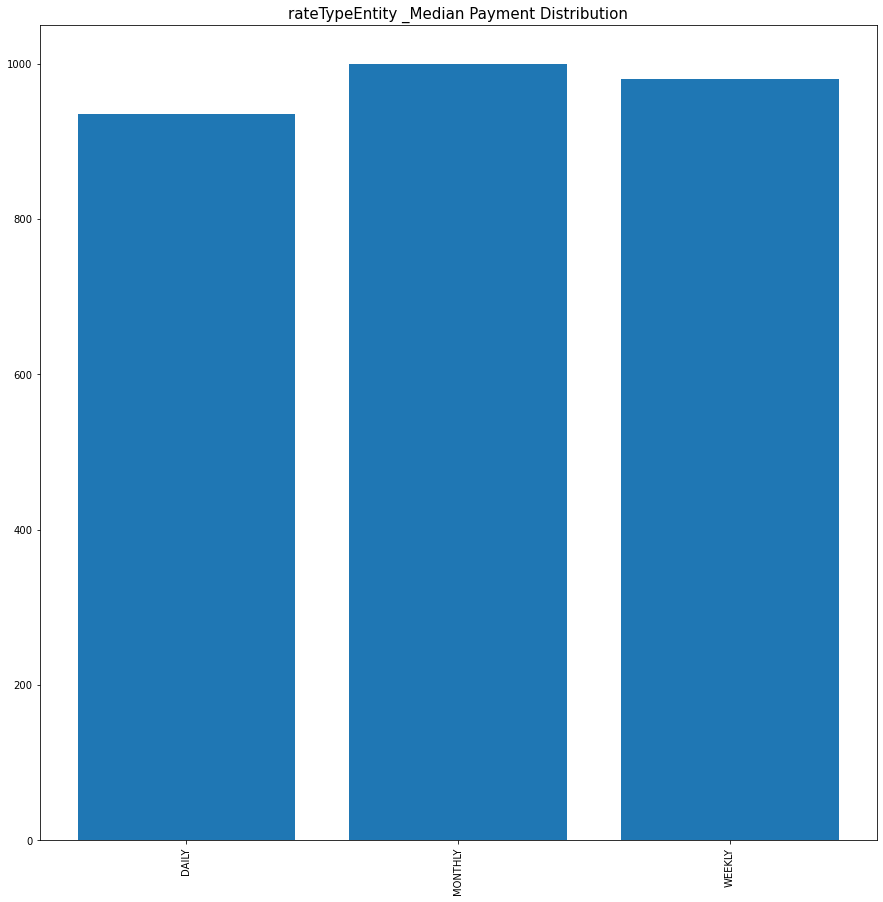

In [172]:
payhist_distribution('rateTypeEntity')

In [173]:
cat_payment_stats('rateTypeEntity')

In [174]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len',
       ...
       'Town_ payment_sum', 'Town_ payment_std', 'Town_ payment_min',
       'Town_ payment_max', 'rateTypeEntity_ payment_mean',
       'rateTypeEntity_ payment_median', 'rateTypeEntity_ payment_sum',
       'rateTypeEntity_ payment_std', 'rateTypeEntity_ payment_min',
       'rateTypeEntity_ payment_max'],
      dtype='object', length=222)

***Analysis- Main Applicant Gender***

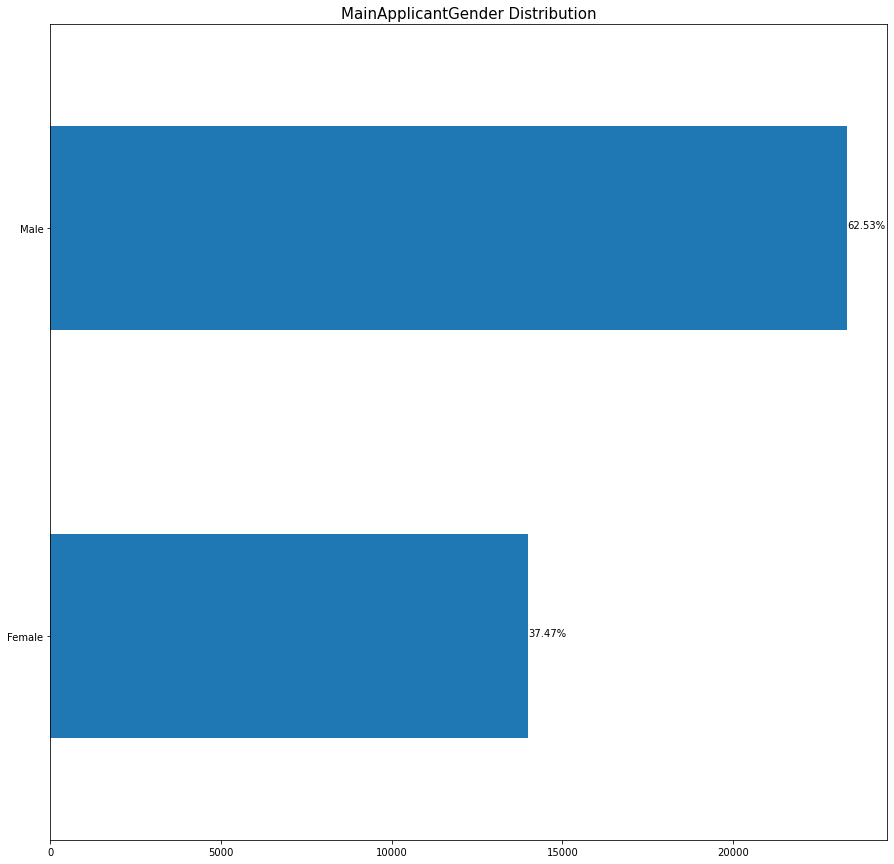

In [175]:
# Main Applicant Gender distribution 
catplot_distribution('MainApplicantGender')

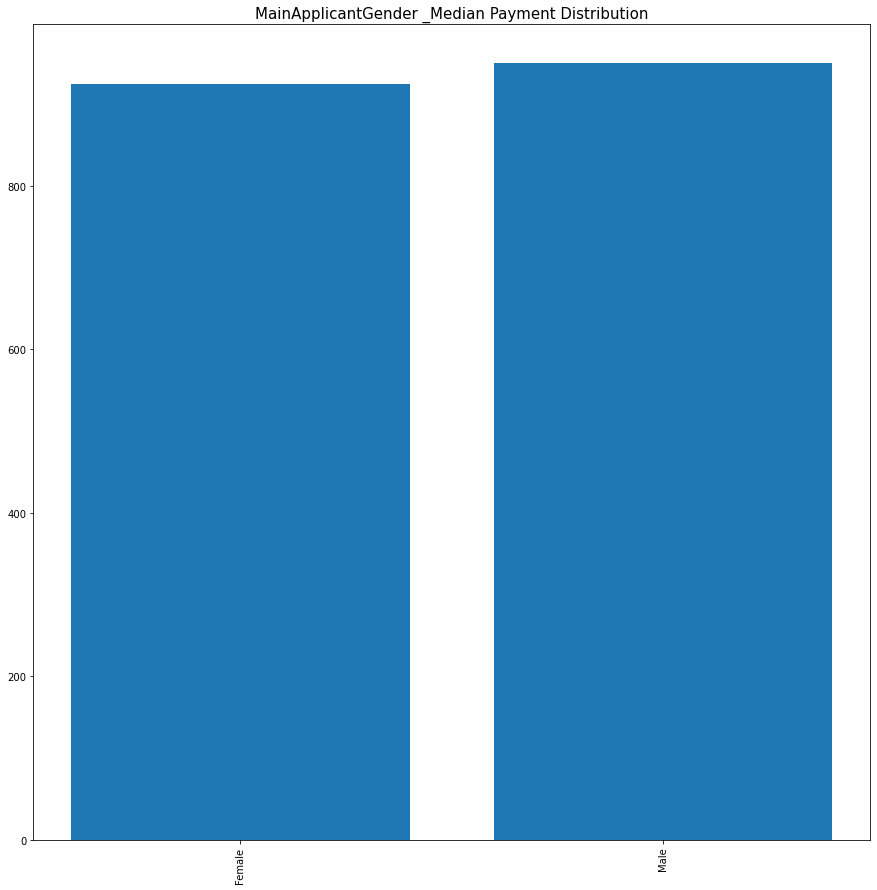

In [176]:
payhist_distribution('MainApplicantGender')

In [177]:
cat_payment_stats('MainApplicantGender')

In [178]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len',
       ...
       'rateTypeEntity_ payment_sum', 'rateTypeEntity_ payment_std',
       'rateTypeEntity_ payment_min', 'rateTypeEntity_ payment_max',
       'MainApplicantGender_ payment_mean',
       'MainApplicantGender_ payment_median',
       'MainApplicantGender_ payment_sum', 'MainApplicantGender_ payment_std',
       'MainApplicantGender_ payment_min', 'MainApplicantGender_ payment_max'],
      dtype='object', length=228)

In [179]:
merged[['MainApplicantGender_ payment_mean', 'MainApplicantGender_ payment_median',
'MainApplicantGender_ payment_sum', 'MainApplicantGender_ payment_std',
'MainApplicantGender_ payment_min', 'MainApplicantGender_ payment_max']]

,MainApplicantGender_ payment_mean,MainApplicantGender_ payment_median,MainApplicantGender_ payment_sum,MainApplicantGender_ payment_std,MainApplicantGender_ payment_min,MainApplicantGender_ payment_max
0,1065.000000,950.0,11590.0,625.015119,250.0,2930.0
1,1065.000000,950.0,11590.0,625.015119,250.0,2930.0
2,1065.000000,950.0,11590.0,625.015119,250.0,2930.0
3,1035.651786,925.0,11660.0,597.796299,240.0,2840.0
4,1065.000000,950.0,11590.0,625.015119,250.0,2930.0
...,...,...,...,...,...,...
37338,1065.000000,950.0,11590.0,625.015119,250.0,2930.0
37339,1065.000000,950.0,11590.0,625.015119,250.0,2930.0
37340,1065.000000,950.0,11590.0,625.015119,250.0,2930.0
37341,1065.000000,950.0,11590.0,625.015119,250.0,2930.0


***Analysis- Term***

In [180]:
merged['Term'].describe()

count    37343.000000
mean       412.427657
std        121.602544
min         10.000000
25%        364.000000
50%        364.000000
75%        547.000000
max        626.000000
Name: Term, dtype: float64

In [181]:
def create_term_brackets(term):

    if term  <= 182:
        
        return '6months'
    
    elif term > 182 and term <= 365:
        
        return '12months'
    
    elif term > 365:
        
        return 'a year+'
    
    else:
        return np.nan
    

In [182]:
merged['Term_brackets'] = merged['Term'].apply(create_term_brackets)

***Create payment statistics by Term***

In [183]:
cat_payment_stats('Term_brackets')

In [184]:
merged.columns

Index(['ID', 'TransactionDates', 'PaymentsHistory', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'payhist_len',
       ...
       'MainApplicantGender_ payment_std', 'MainApplicantGender_ payment_min',
       'MainApplicantGender_ payment_max', 'Term_brackets',
       'Term_brackets_ payment_mean', 'Term_brackets_ payment_median',
       'Term_brackets_ payment_sum', 'Term_brackets_ payment_std',
       'Term_brackets_ payment_min', 'Term_brackets_ payment_max'],
      dtype='object', length=235)

### Final Data Preparation (Loan Status & Payments History)

In [185]:
merged = merged.drop(['TransactionDates', 'RegistrationDate', 'UpsellDate', 'ExpectedTermDate', 'FirstPaymentDate', \
            'LastTransactionDate', 'Date m1', 'Date m2', 'Date m3', 'Date m4', 'Date m5', \
             'Date m6'], axis = 1)

***Loan Status Final Data Preparation***

In [199]:
loan_status = merged.copy()

In [200]:
loan_status = loan_status.reset_index(drop = True)

In [201]:
loan_status.head()

,ID,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,tag,...,MainApplicantGender_ payment_std,MainApplicantGender_ payment_min,MainApplicantGender_ payment_max,Term_brackets,Term_brackets_ payment_mean,Term_brackets_ payment_median,Term_brackets_ payment_sum,Term_brackets_ payment_std,Term_brackets_ payment_min,Term_brackets_ payment_max
0,ID_MR53LEX,"[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,train,...,625.015119,250.0,2930.0,a year+,1158.083333,1100.0,24586.0,651.004326,200.0,3500.0
1,ID_3D7NQUH,"[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,train,...,625.015119,250.0,2930.0,a year+,1158.083333,1100.0,24586.0,651.004326,200.0,3500.0
2,ID_0IWQNPI,"[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,train,...,625.015119,250.0,2930.0,12months,1005.714286,880.0,9844.0,586.976283,280.0,2560.0
3,ID_IY8SYB9,"[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,train,...,597.796299,240.0,2840.0,12months,1005.714286,880.0,9844.0,586.976283,280.0,2560.0
4,ID_9XHL7VZ,"[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,train,...,625.015119,250.0,2930.0,12months,1005.714286,880.0,9844.0,586.976283,280.0,2560.0


In [202]:
%%time
#Target creation(loan status)
loan_status = create_target(loan_status)

Wall time: 37.5 s


In [203]:
loan_status['Target'] 

0         59.431681
1         82.212817
2        100.069444
3        100.000000
4         57.300725
            ...    
37338           NaN
37339           NaN
37340           NaN
37341           NaN
37342           NaN
Name: Target, Length: 37343, dtype: float64

In [204]:
loan_status = loan_status.drop(['PaymentsHistory'], axis = 1)

In [205]:
loan_status.to_pickle('loan_prep.pkl', compression='gzip')

***M1-M6 Payments prediction Final Data Preparation***

In [233]:
merged.head()

,ID,PaymentsHistory,m1,m2,m3,m4,m5,m6,payhist_len,tag,...,MainApplicantGender_ payment_std,MainApplicantGender_ payment_min,MainApplicantGender_ payment_max,Term_brackets,Term_brackets_ payment_mean,Term_brackets_ payment_median,Term_brackets_ payment_sum,Term_brackets_ payment_std,Term_brackets_ payment_min,Term_brackets_ payment_max
0,ID_MR53LEX,"[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,31,train,...,625.015119,250.0,2930.0,a year+,1158.083333,1100.0,24586.0,651.004326,200.0,3500.0
1,ID_3D7NQUH,"[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,30,train,...,625.015119,250.0,2930.0,a year+,1158.083333,1100.0,24586.0,651.004326,200.0,3500.0
2,ID_0IWQNPI,"[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,6,train,...,625.015119,250.0,2930.0,12months,1005.714286,880.0,9844.0,586.976283,280.0,2560.0
3,ID_IY8SYB9,"[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,10,train,...,597.796299,240.0,2840.0,12months,1005.714286,880.0,9844.0,586.976283,280.0,2560.0
4,ID_9XHL7VZ,"[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,22,train,...,625.015119,250.0,2930.0,12months,1005.714286,880.0,9844.0,586.976283,280.0,2560.0


In [234]:
all_cols = list(merged.columns)

use_vars = list(set(all_cols) - set(['m1', 'm2', 'm3', 'm4', 'm5', 'm6']))

In [235]:
all_data = merged.melt(id_vars = use_vars, value_vars = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6'], \
            var_name = 'Target m Month',value_name = 'Target m Payment')

In [237]:
all_data.head()

,Town_ payment_max,DaysOnDeposit,paymentmedian_m6,paymentmeanyr_m2,paymentmax_m1,Contract_Rate_vs_Average_pay,age_group_ payment_sum,RegisteredAtMonthStart,Date m3 month,MainApplicantGender_ payment_mean,...,paymentminyr_m1,Region_ payment_median,Date m4 month,paymentminyr_m3,rateTypeEntity_ payment_max,TermDatetoLastPayment/TermDateto_Date m3,tag,Region_ payment_min,Target m Month,Target m Payment
0,3274.0,3,585.0,NaN,505.0,3.500931,NaN,0.0,2,1065.000000,...,120.0,1100.0,3,NaN,2885.0,0.799564,train,335.0,m1,880.0
1,3200.0,3,935.0,NaN,1100.0,2.454217,9680.0,0.0,2,1065.000000,...,442.0,935.0,3,NaN,2885.0,0.802151,train,240.0,m1,660.0
2,2840.0,3,NaN,1126.666667,NaN,1.620899,7850.0,0.0,10,1065.000000,...,200.0,1010.0,11,200.0,2885.0,7.571429,train,330.0,m1,700.0
3,2900.0,7,900.0,926.666667,NaN,1.229761,9680.0,0.0,9,1035.651786,...,380.0,1010.0,10,380.0,2885.0,8.666667,train,330.0,m1,580.0
4,3000.0,7,370.0,NaN,280.0,3.916137,9680.0,0.0,2,1065.000000,...,40.0,880.0,3,NaN,2885.0,0.821012,train,240.0,m1,40.0


***Create Payment stats based on the target m month- We drop the general statistics created for all months, we use a single m month as a feature and m payment.***

In [240]:
all_data[['paymentmedian_mstats', 'paymentmean_mstats', 'paymentmin_mstats', 'paymentmax_mstats', \
          'paymentstd_mstats', 'paymentsum_mstats', 'paymentlen_mstats', 'paymentmonth_m']] = np.nan

In [241]:
all_data[['paymentmedian_ystats', 'paymentmean_ystats', 'paymentmin_ystats', 'paymentmax_ystats', \
          'paymentstd_ystats', 'paymentsum_ystats', 'paymentlen_ystats', 'paymentyear_m']] = np.nan

In [242]:
def extract_pay_targetmonth(df):
    
    
    
    month_m = df['Target m Month']
    
    target_month = df['Date ' + month_m + ' month']
    
    median = df['paymentmedian_' + month_m]
    
    std = df['paymentstd_' + month_m]
    
    minn = df['paymentmin_' + month_m]
    
    maxx = df['paymentmax_' + month_m]
    
    meann = df['paymentmean_' + month_m]
        
    summ = df['paymentsum_' + month_m]
        
    lent = df['paymentlen_' + month_m]
    
        
                            
        
            
    return pd.Series([median, meann, minn, maxx, std, summ, lent, target_month])

In [243]:
all_data[['paymentmedian_mstats', 'paymentmean_mstats', 'paymentmin_mstats', 'paymentmax_mstats', \
          'paymentstd_mstats', 'paymentsum_mstats', 'paymentlen_mstats', 'paymentmonth_m']]= \
all_data.apply(extract_pay_targetmonth, axis = 1)     

In [244]:
def extract_pay_targetyear(df):
    
    
    
    year_m = df['Target m Month']
    
    target_year = df['Date ' + year_m + ' year']
    
    median = df['paymentmedianyr_' + year_m]
    
    std = df['paymentstdyr_' + year_m]
    
    minn = df['paymentminyr_' + year_m]
    
    maxx = df['paymentmaxyr_' + year_m]
    
    meann = df['paymentmeanyr_' + year_m]
        
    summ = df['paymentsumyr_' + year_m]
        
    lent = df['paymentlenyr_' + year_m]
    
        
                            
        
            
    return pd.Series([median, meann, minn, maxx, std, summ, lent, target_year])

In [245]:
all_data[['paymentmedian_ystats', 'paymentmean_ystats', 'paymentmin_ystats', 'paymentmax_ystats', \
          'paymentstd_ystats', 'paymentsum_ystats', 'paymentlen_ystats', 'paymentyear_m']]= \
all_data.apply(extract_pay_targetyear, axis = 1)     

In [246]:
all_data.head()

,Town_ payment_max,DaysOnDeposit,paymentmedian_m6,paymentmeanyr_m2,paymentmax_m1,Contract_Rate_vs_Average_pay,age_group_ payment_sum,RegisteredAtMonthStart,Date m3 month,MainApplicantGender_ payment_mean,...,paymentlen_mstats,paymentmonth_m,paymentmedian_ystats,paymentmean_ystats,paymentmin_ystats,paymentmax_ystats,paymentstd_ystats,paymentsum_ystats,paymentlen_ystats,paymentyear_m
0,3274.0,3,585.0,NaN,505.0,3.500931,NaN,0.0,2,1065.000000,...,2.0,12.0,390.0,550.000000,120.0,1320.0,389.054799,6050.0,11.0,2020.0
1,3200.0,3,935.0,NaN,1100.0,2.454217,9680.0,0.0,2,1065.000000,...,2.0,12.0,639.0,607.363636,442.0,770.0,90.522998,6681.0,11.0,2020.0
2,2840.0,3,NaN,1126.666667,NaN,1.620899,7850.0,0.0,10,1065.000000,...,NaN,8.0,980.0,1126.666667,200.0,2850.0,917.726660,6760.0,6.0,2020.0
3,2900.0,7,900.0,926.666667,NaN,1.229761,9680.0,0.0,9,1035.651786,...,NaN,7.0,940.0,926.666667,380.0,1400.0,369.804753,5560.0,6.0,2018.0
4,3000.0,7,370.0,NaN,280.0,3.916137,9680.0,0.0,2,1065.000000,...,2.0,12.0,80.0,125.714286,40.0,520.0,162.027964,880.0,7.0,2019.0


In [247]:
def Extract_termdatem(df):
    
    m_month = df['Target m Month']
    
    m_feature = df['TermDateto_' + 'Date ' + m_month]
            
    return m_feature

In [248]:
##new
all_data['TermDateto_m'] = all_data.apply(Extract_termdatem, axis = 1)

In [249]:
all_data.head()

,Town_ payment_max,DaysOnDeposit,paymentmedian_m6,paymentmeanyr_m2,paymentmax_m1,Contract_Rate_vs_Average_pay,age_group_ payment_sum,RegisteredAtMonthStart,Date m3 month,MainApplicantGender_ payment_mean,...,paymentmonth_m,paymentmedian_ystats,paymentmean_ystats,paymentmin_ystats,paymentmax_ystats,paymentstd_ystats,paymentsum_ystats,paymentlen_ystats,paymentyear_m,TermDateto_m
0,3274.0,3,585.0,NaN,505.0,3.500931,NaN,0.0,2,1065.000000,...,12.0,390.0,550.000000,120.0,1320.0,389.054799,6050.0,11.0,2020.0,-397
1,3200.0,3,935.0,NaN,1100.0,2.454217,9680.0,0.0,2,1065.000000,...,12.0,639.0,607.363636,442.0,770.0,90.522998,6681.0,11.0,2020.0,-403
2,2840.0,3,NaN,1126.666667,NaN,1.620899,7850.0,0.0,10,1065.000000,...,8.0,980.0,1126.666667,200.0,2850.0,917.726660,6760.0,6.0,2020.0,75
3,2900.0,7,900.0,926.666667,NaN,1.229761,9680.0,0.0,9,1035.651786,...,7.0,940.0,926.666667,380.0,1400.0,369.804753,5560.0,6.0,2018.0,74
4,3000.0,7,370.0,NaN,280.0,3.916137,9680.0,0.0,2,1065.000000,...,12.0,80.0,125.714286,40.0,520.0,162.027964,880.0,7.0,2019.0,-452


In [250]:
def Extract_termdate_ratio(df):
    
    m_month = df['Target m Month']
    
    m_feature = df['TermDatetoLastPayment/TermDateto_Date ' + m_month]
            
    return m_feature

In [251]:
##new
all_data['TermDatetoratio_m'] = all_data.apply(Extract_termdate_ratio, axis = 1)

In [252]:
all_data.head()

,Town_ payment_max,DaysOnDeposit,paymentmedian_m6,paymentmeanyr_m2,paymentmax_m1,Contract_Rate_vs_Average_pay,age_group_ payment_sum,RegisteredAtMonthStart,Date m3 month,MainApplicantGender_ payment_mean,...,paymentmedian_ystats,paymentmean_ystats,paymentmin_ystats,paymentmax_ystats,paymentstd_ystats,paymentsum_ystats,paymentlen_ystats,paymentyear_m,TermDateto_m,TermDatetoratio_m
0,3274.0,3,585.0,NaN,505.0,3.500931,NaN,0.0,2,1065.000000,...,390.0,550.000000,120.0,1320.0,389.054799,6050.0,11.0,2020.0,-397,0.924433
1,3200.0,3,935.0,NaN,1100.0,2.454217,9680.0,0.0,2,1065.000000,...,639.0,607.363636,442.0,770.0,90.522998,6681.0,11.0,2020.0,-403,0.925558
2,2840.0,3,NaN,1126.666667,NaN,1.620899,7850.0,0.0,10,1065.000000,...,980.0,1126.666667,200.0,2850.0,917.726660,6760.0,6.0,2020.0,75,1.413333
3,2900.0,7,900.0,926.666667,NaN,1.229761,9680.0,0.0,9,1035.651786,...,940.0,926.666667,380.0,1400.0,369.804753,5560.0,6.0,2018.0,74,1.405405
4,3000.0,7,370.0,NaN,280.0,3.916137,9680.0,0.0,2,1065.000000,...,80.0,125.714286,40.0,520.0,162.027964,880.0,7.0,2019.0,-452,0.933628


In [253]:
id_col = all_data.pop('ID')

In [254]:
m_col = all_data.pop('Target m Month')

In [255]:
pay_col = all_data.pop('Target m Payment')

In [256]:
all_data.insert(0, 'ID', id_col)

all_data.insert(1, 'Target m Month', m_col)

all_data.insert(2, 'Target m Payment', pay_col)

In [257]:
all_data.head()

,ID,Target m Month,Target m Payment,Town_ payment_max,DaysOnDeposit,paymentmedian_m6,paymentmeanyr_m2,paymentmax_m1,Contract_Rate_vs_Average_pay,age_group_ payment_sum,...,paymentmedian_ystats,paymentmean_ystats,paymentmin_ystats,paymentmax_ystats,paymentstd_ystats,paymentsum_ystats,paymentlen_ystats,paymentyear_m,TermDateto_m,TermDatetoratio_m
0,ID_MR53LEX,m1,880.0,3274.0,3,585.0,NaN,505.0,3.500931,NaN,...,390.0,550.000000,120.0,1320.0,389.054799,6050.0,11.0,2020.0,-397,0.924433
1,ID_3D7NQUH,m1,660.0,3200.0,3,935.0,NaN,1100.0,2.454217,9680.0,...,639.0,607.363636,442.0,770.0,90.522998,6681.0,11.0,2020.0,-403,0.925558
2,ID_0IWQNPI,m1,700.0,2840.0,3,NaN,1126.666667,NaN,1.620899,7850.0,...,980.0,1126.666667,200.0,2850.0,917.726660,6760.0,6.0,2020.0,75,1.413333
3,ID_IY8SYB9,m1,580.0,2900.0,7,900.0,926.666667,NaN,1.229761,9680.0,...,940.0,926.666667,380.0,1400.0,369.804753,5560.0,6.0,2018.0,74,1.405405
4,ID_9XHL7VZ,m1,40.0,3000.0,7,370.0,NaN,280.0,3.916137,9680.0,...,80.0,125.714286,40.0,520.0,162.027964,880.0,7.0,2019.0,-452,0.933628


In [258]:
all_data = all_data.sort_values(['ID', 'Target m Month'])

In [232]:
all_data['PaymentsHistory']

0        [3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...
1        [2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...
2            [2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]
3        [2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...
4        [2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...
                               ...                        
37338    [2690.0, 270.0, 770.0, 1100.0, 700.0, 550.0, 5...
37339    [2950.0, 1550.0, 1500.0, 900.0, 80.0, 1550.0, ...
37340    [2550.0, 500.0, 550.0, 250.0, 200.0, 450.0, 45...
37341    [2700.0, 800.0, 250.0, 300.0, 1100.0, 950.0, 8...
37342             [2300.0, 1320.0, 1050.0, 1300.0, 1150.0]
Name: PaymentsHistory, Length: 37343, dtype: object

In [259]:
all_data = all_data.drop(['PaymentsHistory'], axis = 1)

In [260]:
cols = list()

for i in ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']:
    
    cols.extend(['paymentmedian_' + i, 'paymentmean_' + i, 'paymentmin_' + i, 'paymentmax_' + i, 'paymentstd_' + i, \
                 'paymentsum_' + i, 'paymentlen_' + i, 'Date '+ i + ' month', 'paymentmedianyr_' + i, 'paymentmeanyr_' + i, 'paymentminyr_' + i, 'paymentmaxyr_' + i, 'paymentstdyr_' + i, \
                 'paymentsumyr_' + i, 'paymentlenyr_' + i, 'Date '+ i + ' year', 'TermDateto_Date ' + i, \
                'TermDatetoLastPayment/TermDateto_Date ' + i])
    
all_data = all_data.drop(cols, axis = 1)

In [261]:
all_data.head()

,ID,Target m Month,Target m Payment,Town_ payment_max,DaysOnDeposit,Contract_Rate_vs_Average_pay,age_group_ payment_sum,RegisteredAtMonthStart,MainApplicantGender_ payment_mean,Town,...,paymentmedian_ystats,paymentmean_ystats,paymentmin_ystats,paymentmax_ystats,paymentstd_ystats,paymentsum_ystats,paymentlen_ystats,paymentyear_m,TermDateto_m,TermDatetoratio_m
29057,ID_000RHRU,m1,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,120.0,210.0,40.0,700.0,224.425192,1260.0,6.0,2019.0,-458,0.932314
66400,ID_000RHRU,m2,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,120.0,210.0,40.0,700.0,224.425192,1260.0,6.0,2019.0,-488,0.875000
103743,ID_000RHRU,m3,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,-519,0.822736
141086,ID_000RHRU,m4,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,-550,0.776364
178429,ID_000RHRU,m5,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,-579,0.737478


In [262]:
all_data = all_data.reset_index(drop = True)

In [263]:
all_data.head()

,ID,Target m Month,Target m Payment,Town_ payment_max,DaysOnDeposit,Contract_Rate_vs_Average_pay,age_group_ payment_sum,RegisteredAtMonthStart,MainApplicantGender_ payment_mean,Town,...,paymentmedian_ystats,paymentmean_ystats,paymentmin_ystats,paymentmax_ystats,paymentstd_ystats,paymentsum_ystats,paymentlen_ystats,paymentyear_m,TermDateto_m,TermDatetoratio_m
0,ID_000RHRU,m1,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,120.0,210.0,40.0,700.0,224.425192,1260.0,6.0,2019.0,-458,0.932314
1,ID_000RHRU,m2,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,120.0,210.0,40.0,700.0,224.425192,1260.0,6.0,2019.0,-488,0.875000
2,ID_000RHRU,m3,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,-519,0.822736
3,ID_000RHRU,m4,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,-550,0.776364
4,ID_000RHRU,m5,NaN,2720.0,7,2.762215,11080.0,1.0,1035.651786,Nandi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,-579,0.737478


In [264]:
ss.head()

,ID,Target
0,ID_6L67PAA x m1,0.0
1,ID_6L67PAA x m2,0.0
2,ID_6L67PAA x m3,0.0
3,ID_6L67PAA x m4,0.0
4,ID_6L67PAA x m5,0.0


In [265]:
all_data.to_pickle('data_prep.pkl', compression='gzip')

In [266]:
import gc
gc.collect()

0